<a href="https://colab.research.google.com/github/skarskar/MLWorkshop/blob/main/capstone-project/V2_Capstone_Loan_Default_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install category_encoders
!pip install feature_engine
!pip install scikit-learn==1.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 59.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
# mlp for binary classification
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import category_encoders as ce
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction import DictVectorizer
from scipy.stats.mstats import winsorize
#from category_encoders import TargetEncoder
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss, classification_report, accuracy_score,  roc_auc_score, roc_curve, auc
%matplotlib inline

In [ ]:
%time
# Set your environment in a notebook:
# Set the Environment
# Ignore Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Write out the versions of all packages to requirements.txt
!pip freeze >> requirements.txt

# Remove the restriction on Jupyter that limits the columns displayed (the ... in the middle)
# pd.set_option('max_columns',None)
pd.options.display.max_columns = None
pd.options.display.max_rows = None
# Docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.set_option.html#

# Pretty Display of variables.  for instance, you can call df.head() and df.tail() in the same cell and BOTH display w/o print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# List of ALL Magic Commands.  To run a magic command %var  --- i.e.:  %env
%lsmagic
# %env  -- list environment variables
# %%time  -- gives you information about how long a cel took to run
# %%timeit -- runs a cell 100,000 times and then gives you the average time the cell will take to run (can be LONG)
# %pdb -- python debugger

# to display nice model diagram
from sklearn import set_config
set_config(display='diagram')

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.30"

import tensorflow
print("\n tensorflow: " + tensorflow.__version__)

print("\n Numpy: " + np.__version__)
print("\n sklearn: " + sklearn.__version__)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.44 µs

 tensorflow: 2.13.0

 Numpy: 1.23.5

 sklearn: 1.3.1


# Methods

In [ ]:
# prepare input data
def prepare_inputs(X_train, X_test):
  #https://towardsdatascience.com/dealing-with-categorical-variables-by-using-target-encoder-a0f1733a4c69
 #oe = ce.CountEncoder()
 #oe.fit(X_train)
  encoder = TargetEncoder(smooth='auto', target_type='binary')
  X_train = encoder.fit_transform(X_train.drop(columns='loan_default_status'), X_train['loan_default_status'])
  X_train_enc = X_train #pd.get_dummies(X_train) #oe.transform(X_train)
  #X_test_enc = X_test #pd.get_dummies(X_test)  #oe.transform(X_test)
  return X_train_enc#, X_test_enc

 # prepare target
def prepare_targets(y_train, y_test):
  le = LabelEncoder()
  le.fit(y_train)
  y_train_enc = le.transform(y_train)
  y_test_enc = le.transform(y_test)
  return y_train_enc, y_test_enc

 # feature selection based on chi2
def select_features(X_train, y_train, X_test):
  fs = SelectKBest(score_func=chi2, k=1)
  fs.fit(X_train, y_train)
  X_train_fs = fs.transform(X_train)
  X_test_fs = fs.transform(X_test)
  return X_train_fs, X_test_fs, fs

 # feature selection based on Mutual Importance
def select_features_mutual_info(X_train, y_train, X_test):
  fs = SelectKBest(score_func=mutual_info_classif, k=1)
  fs.fit(X_train, y_train)
  X_train_fs = fs.transform(X_train)
  X_test_fs = fs.transform(X_test)
  return X_train_fs, X_test_fs, fs

# Load Data

In [ ]:
'''
ID: unique ID of representative
Loan Amount: loan amount applied
Funded Amount:The total amount committed to that loan at that point in time.
Funded Amount Investor: The total amount committed by investors for that loan at that point in time.
Term: term of loan (in months)
Batch Enrolled: batch numbers to representatives
Interest Rate: interest rate (%) on loan
Grade: grade by the bank
Sub Grade: sub-grade by the bank
Debit to Income: ratio of representative's total monthly debt repayment divided by self reported monthly income excluding mortgage
Delinquency - two years: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
Inquires - six months: total number of inquiries in last 6 months
Open Account: number of open credit line in representative's - credit line
Public Record: number of derogatory public records
Revolving Balance: total credit revolving balance
Revolving Utilities: amount of credit a representative is using - relative to revolving_balance
Total Accounts: total number of credit lines available in - representatives credit line
Initial List Status: unique listing status of the loan - - W(Waiting), F(Forwarded)
Total Received Interest: total interest received till date
Total Received Late Fee: total late fee received till date
Recoveries: post charge off gross recovery
Collection Recovery Fee: post charge off collection fee
Collection 12 months Medical: total collections in last 12 months - excluding medical collections
Application Type: indicates when the representative is an individual or joint
Last week Pay: indicates how long (in weeks) a representative has paid EMI after batch enrolled
Accounts Delinquent: number of accounts on which the representative is delinquent
Total Collection Amount: total collection amount ever owed
Total Current Balance: total current balance from all accounts
Total Revolving Credit Limit: total revolving credit limit
Loan Status: 1 = Defaulter, 0 = Non Defaulters
verification_status: Indicates if income was verified by LC, not verified, or if the income source was verified
Home Ownership: The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.
'''

path = 'https://raw.githubusercontent.com/skarskar/MLWorkshop/main/dataset/Loan%20Default%20prediction%20dataset%20Train.csv'
df_test=pd.read_csv("https://raw.githubusercontent.com/skarskar/MLWorkshop/main/dataset/Loan%20Default%20prediction%20dataset%20Test.csv")
df= read_csv(path)
df.head(5)


"\nID: unique ID of representative\nLoan Amount: loan amount applied\nFunded Amount:The total amount committed to that loan at that point in time.\nFunded Amount Investor: The total amount committed by investors for that loan at that point in time.\nTerm: term of loan (in months)\nBatch Enrolled: batch numbers to representatives\nInterest Rate: interest rate (%) on loan\nGrade: grade by the bank\nSub Grade: sub-grade by the bank\nDebit to Income: ratio of representative's total monthly debt repayment divided by self reported monthly income excluding mortgage\nDelinquency - two years: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years\nInquires - six months: total number of inquiries in last 6 months\nOpen Account: number of open credit line in representative's - credit line\nPublic Record: number of derogatory public records\nRevolving Balance: total credit revolving balance\nRevolving Utilities: amount of credit a representativ

ID  Loan Amount  Funded Amount  Funded Amount Investor  Term  \
0  65087372        10000          32236             12329.36286    59   
1   1450153         3609          11940             12191.99692    59   
2   1969101        28276           9311             21603.22455    59   
3   6651430        11170           6954             17877.15585    59   
4  14354669        16890          13226             13539.92667    59   

  Batch Enrolled  Interest Rate Grade Sub Grade Employment Duration  \
0     BAT2522922      11.135007     B        C4            MORTGAGE   
1     BAT1586599      12.237563     C        D3                RENT   
2     BAT2136391      12.545884     F        D4            MORTGAGE   
3     BAT2428731      16.731201     C        C3            MORTGAGE   
4     BAT5341619      15.008300     C        D4            MORTGAGE   

   Home Ownership Verification Status Payment Plan               Loan Title  \
0    176346.62670        Not Verified            n       Debt Consolidation   
1     39833.92100     Source Verified            n       Debt consolidation   
2     91506.69105     Source Verified            n       Debt Consolidation   
3    108286.57590     Source Verified            n       Debt consolidation   
4     44234.82545     Source Verified            n  Credit card refinancing   

   Debit to Income  Delinquency - two years  Inquires - six months  \
0        16.284758                        1                      0   
1        15.412409                        0                      0   
2        28.137619                        0                      0   
3        18.043730                        1                      0   
4        17.209886                        1                      3   

   Open Account  Public Record  Revolving Balance  Revolving Utilities  \
0            13              0              24246            74.932551   
1            12              0                812            78.297186   
2            14              0               1843             2.073040   
3             7              0              13819            67.467951   
4            13              1               1544            85.250761   

   Total Accounts Initial List Status  Total Received Interest  \
0               7                   w              2929.646315   
1              13                   f               772.769385   
2              20                   w               863.324396   
3              12                   w               288.173196   
4              22                   w               129.239553   

   Total Received Late Fee   Recoveries  Collection Recovery Fee  \
0                 0.102055     2.498291                 0.793724   
1                 0.036181     2.377215                 0.974821   
2                18.778660     4.316277                 1.020075   
3                 0.044131     0.107020                 0.749971   
4                19.306646  1294.818751                 0.368953   

   Collection 12 months Medical Application Type  Last week Pay  \
0                             0       INDIVIDUAL             49   
1                             0       INDIVIDUAL            109   
2                             0       INDIVIDUAL             66   
3                             0       INDIVIDUAL             39   
4                             0       INDIVIDUAL             18   

   Accounts Delinquent  Total Collection Amount  Total Current Balance  \
0                    0                       31                 311301   
1                    0                       53                 182610   
2                    0                       34                  89801   
3                    0                       40                   9189   
4                    0                      430                 126029   

   Total Revolving Credit Limit  Loan Status  
0                          6619            0  
1                         20885            0  
2      

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            67463 non-null  int64  
 1   Loan Amount                   67463 non-null  int64  
 2   Funded Amount                 67463 non-null  int64  
 3   Funded Amount Investor        67463 non-null  float64
 4   Term                          67463 non-null  int64  
 5   Batch Enrolled                67463 non-null  object 
 6   Interest Rate                 67463 non-null  float64
 7   Grade                         67463 non-null  object 
 8   Sub Grade                     67463 non-null  object 
 9   Employment Duration           67463 non-null  object 
 10  Home Ownership                67463 non-null  float64
 11  Verification Status           67463 non-null  object 
 12  Payment Plan                  67463 non-null  object 
 13  L

In [ ]:
df.nunique()

ID                              67463
Loan Amount                     27525
Funded Amount                   24548
Funded Amount Investor          67441
Term                                3
Batch Enrolled                     41
Interest Rate                   67448
Grade                               7
Sub Grade                          35
Employment Duration                 3
Home Ownership                  67454
Verification Status                 3
Payment Plan                        1
Loan Title                        109
Debit to Income                 67454
Delinquency - two years             9
Inquires - six months               6
Open Account                       36
Public Record                       5
Revolving Balance               20582
Revolving Utilities             67458
Total Accounts                     69
Initial List Status                 2
Total Received Interest         67451
Total Received Late Fee         67380
Recoveries                      67387
Collection R

In [ ]:
df.isna().sum()

ID                              0
Loan Amount                     0
Funded Amount                   0
Funded Amount Investor          0
Term                            0
Batch Enrolled                  0
Interest Rate                   0
Grade                           0
Sub Grade                       0
Employment Duration             0
Home Ownership                  0
Verification Status             0
Payment Plan                    0
Loan Title                      0
Debit to Income                 0
Delinquency - two years         0
Inquires - six months           0
Open Account                    0
Public Record                   0
Revolving Balance               0
Revolving Utilities             0
Total Accounts                  0
Initial List Status             0
Total Received Interest         0
Total Received Late Fee         0
Recoveries                      0
Collection Recovery Fee         0
Collection 12 months Medical    0
Application Type                0
Last week Pay 

# Preprocessing
## split data into train, validation & test at the earliest so that bias is not introduced.

In [ ]:
df.rename(columns={'Loan Status': 'Loan Default Status', 'Employment Duration': 'Home Ownership','Home Ownership':'Annual Income'}, inplace=True)

#drop columns as these only have 1 unique value
df.drop(columns=['Payment Plan','Accounts Delinquent'], inplace=True)
df.drop(columns=['ID'], inplace=True)

In [ ]:
# change columns & categorical column values to lower case and replace space with hyphen
df.columns = df.columns.str.lower().str.replace(' ', '_')
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')
df.head(1).T

0
loan_amount                                10000
funded_amount                              32236
funded_amount_investor               12329.36286
term                                          59
batch_enrolled                        bat2522922
interest_rate                          11.135007
grade                                          b
sub_grade                                     c4
home_ownership                          mortgage
annual_income                        176346.6267
verification_status                 not_verified
loan_title                    debt_consolidation
debit_to_income                        16.284758
delinquency_-_two_years                        1
inquires_-_six_months                          0
open_account                                  13
public_record                                  0
revolving_balance                          24246
revolving_utilities                    74.932551
total_accounts                                 7
initial_list_status                            w
total_received_interest              2929.646315
total_received_late_fee                 0.102055
recoveries                              2.498291
collection_recovery_fee                 0.793724
collection_12_months_medical                   0
application_type                      individual
last_week_pay                                 49
total_collection_amount                       31
total_current_balance                     311301
total_revolving_credit_limit                6619
loan_default_status                            0

In [ ]:
#check for duplicates
df.drop_duplicates(inplace=True)

In [ ]:
df.select_dtypes(exclude='object').drop(columns='loan_default_status').describe().T

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'loan_amount')

<Axes: >

<ipython-input-163-1cc189c37dca>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)


<Axes: xlabel='loan_amount', ylabel='Density'>

Text(0.5, 1.0, 'loan_amount')

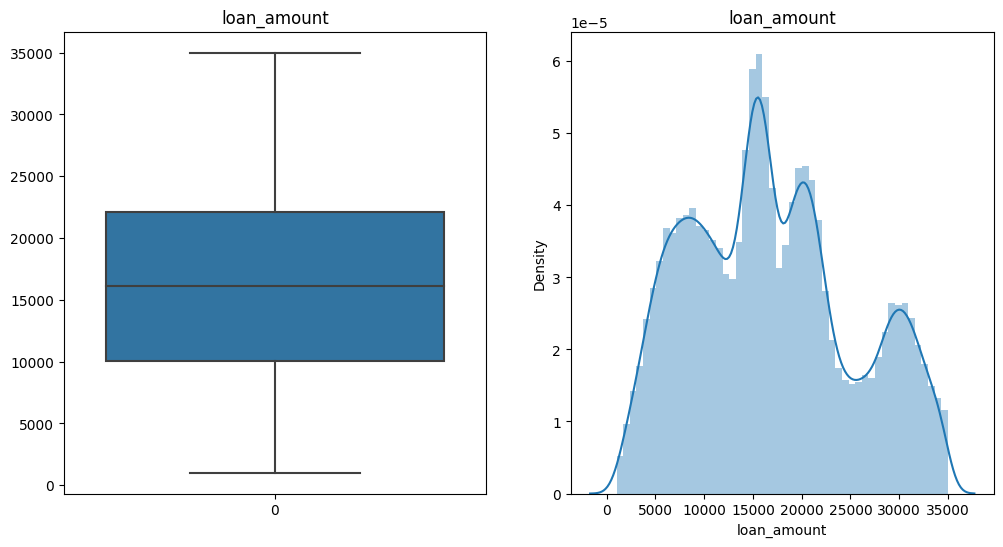

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'funded_amount')

<Axes: >

<ipython-input-163-1cc189c37dca>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)


<Axes: xlabel='funded_amount', ylabel='Density'>

Text(0.5, 1.0, 'funded_amount')

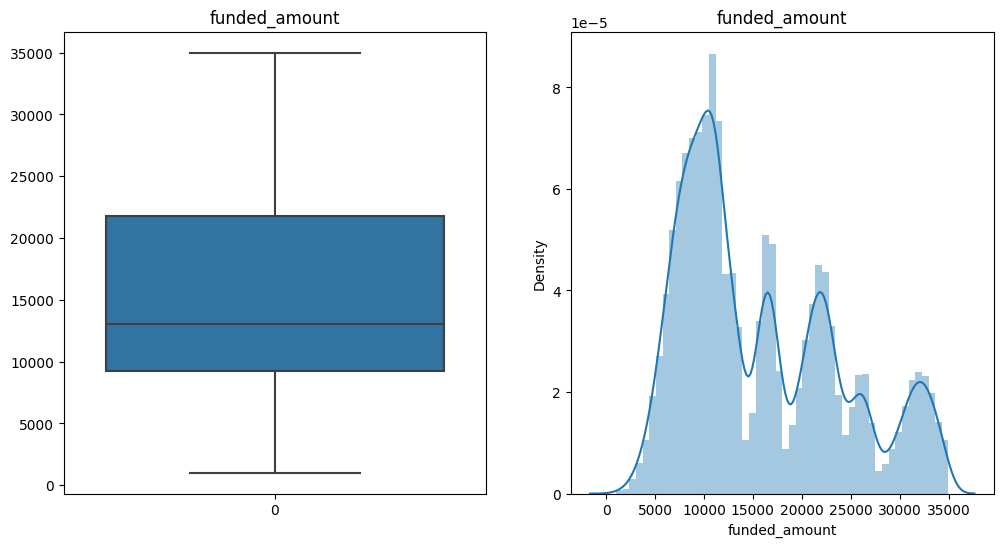

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'funded_amount_investor')

<Axes: >

<ipython-input-163-1cc189c37dca>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)


<Axes: xlabel='funded_amount_investor', ylabel='Density'>

Text(0.5, 1.0, 'funded_amount_investor')

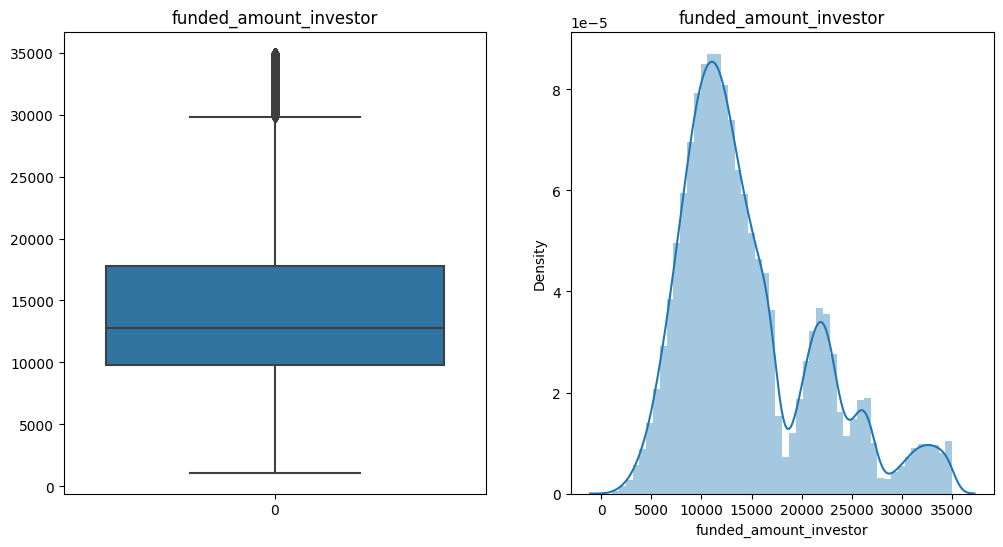

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'term')

<Axes: >

<ipython-input-163-1cc189c37dca>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)


<Axes: xlabel='term', ylabel='Density'>

Text(0.5, 1.0, 'term')

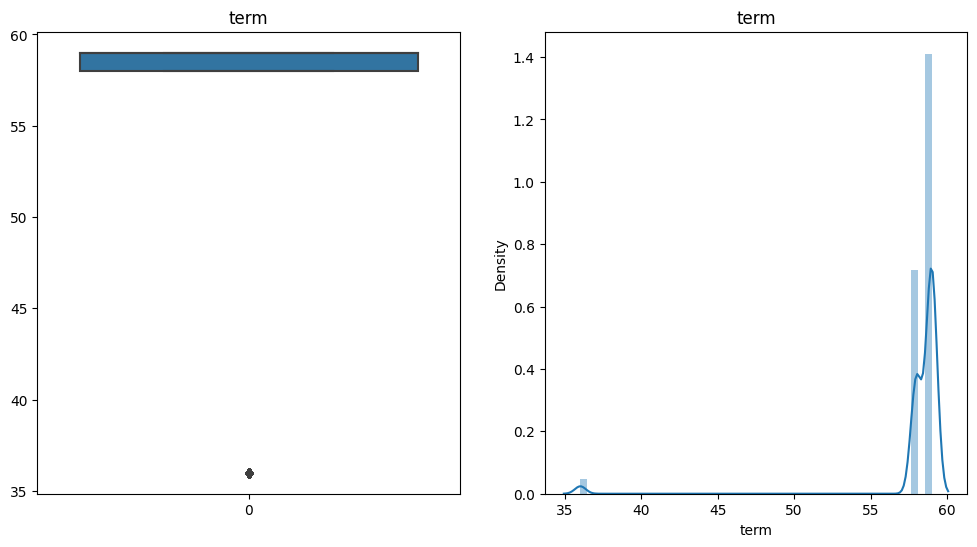

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'interest_rate')

<Axes: >

<ipython-input-163-1cc189c37dca>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)


<Axes: xlabel='interest_rate', ylabel='Density'>

Text(0.5, 1.0, 'interest_rate')

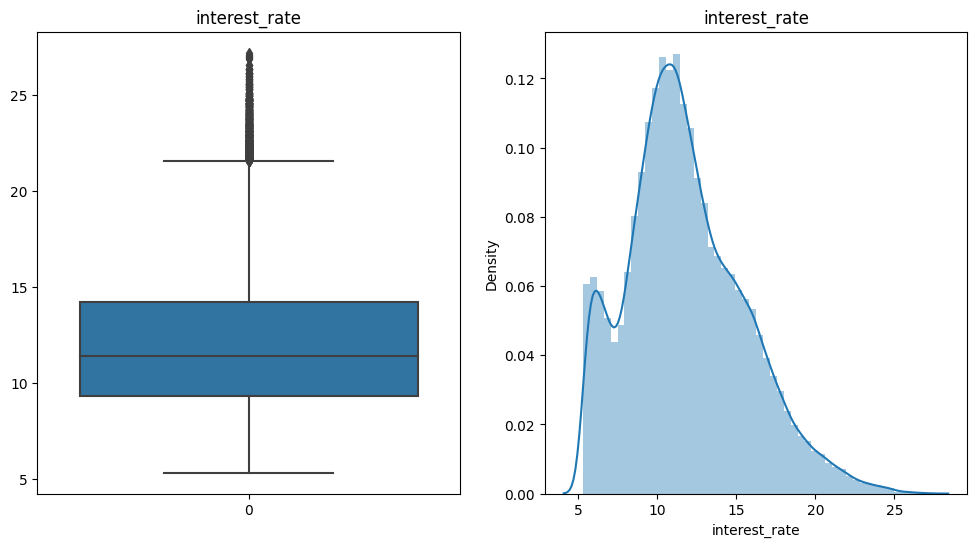

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'annual_income')

<Axes: >

<ipython-input-163-1cc189c37dca>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)


<Axes: xlabel='annual_income', ylabel='Density'>

Text(0.5, 1.0, 'annual_income')

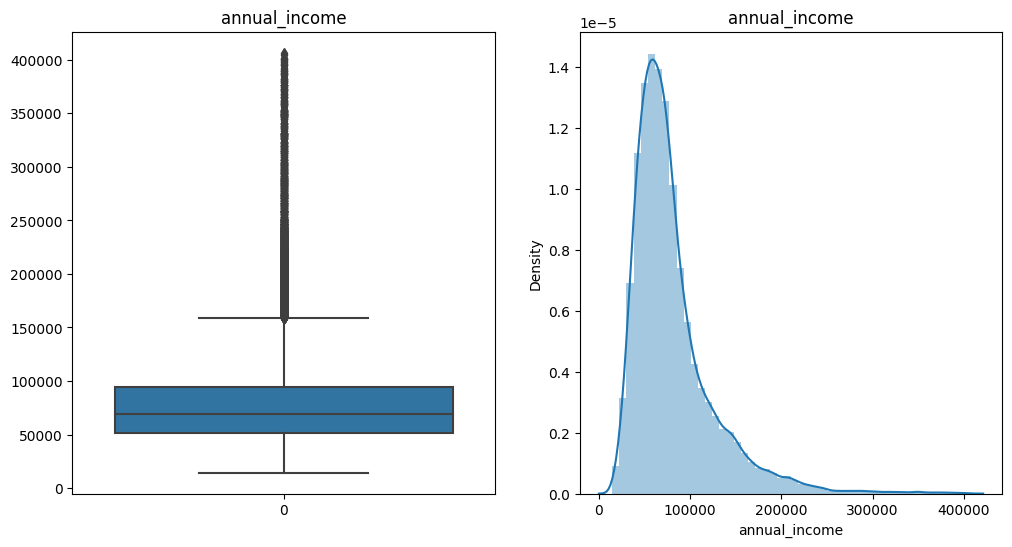

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'debit_to_income')

<Axes: >

<ipython-input-163-1cc189c37dca>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)


<Axes: xlabel='debit_to_income', ylabel='Density'>

Text(0.5, 1.0, 'debit_to_income')

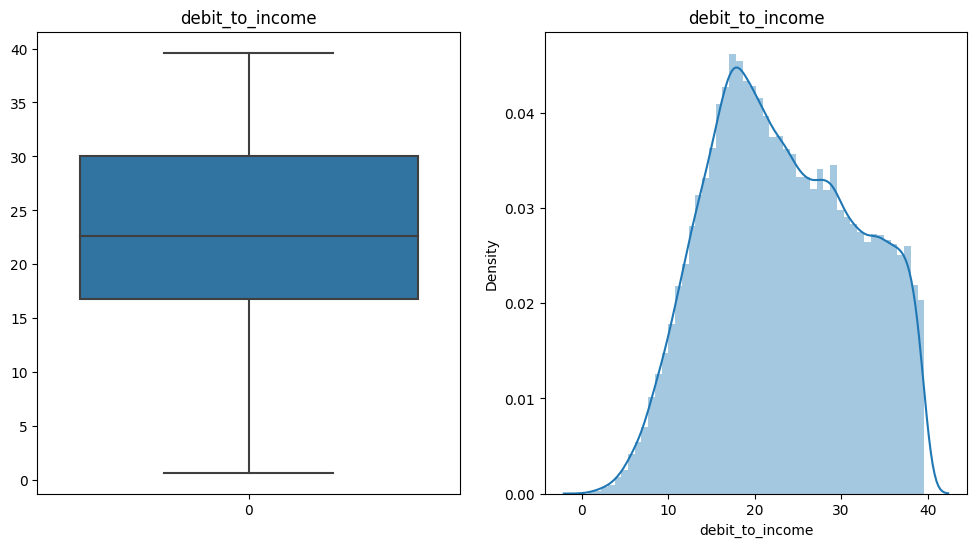

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'delinquency_-_two_years')

<Axes: >

<ipython-input-163-1cc189c37dca>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)


<Axes: xlabel='delinquency_-_two_years', ylabel='Density'>

Text(0.5, 1.0, 'delinquency_-_two_years')

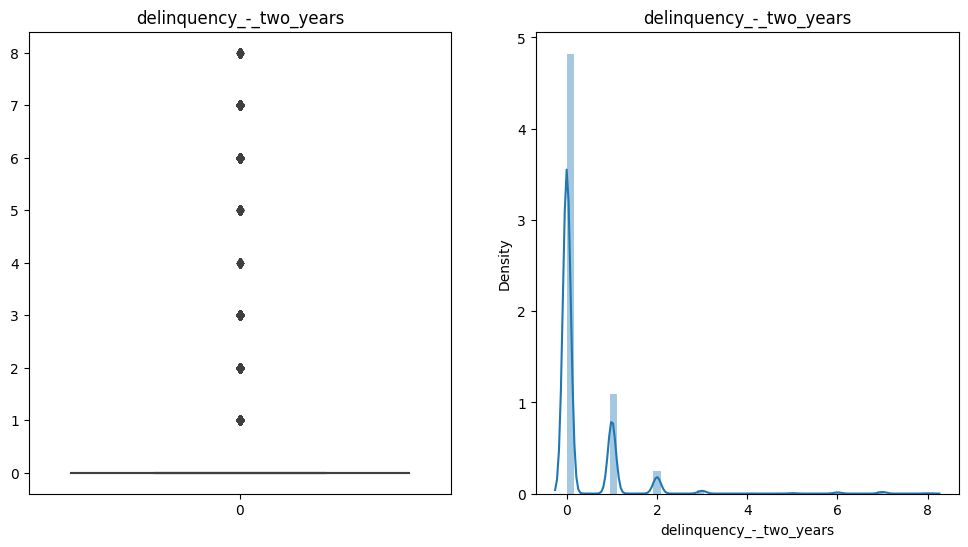

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'inquires_-_six_months')

<Axes: >

<ipython-input-163-1cc189c37dca>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)


<Axes: xlabel='inquires_-_six_months', ylabel='Density'>

Text(0.5, 1.0, 'inquires_-_six_months')

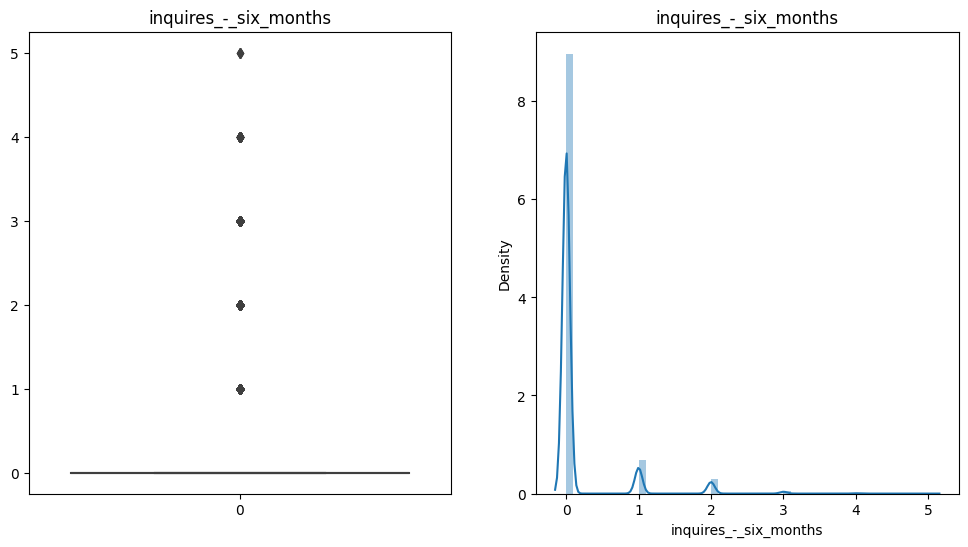

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'open_account')

<Axes: >

<ipython-input-163-1cc189c37dca>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)


<Axes: xlabel='open_account', ylabel='Density'>

Text(0.5, 1.0, 'open_account')

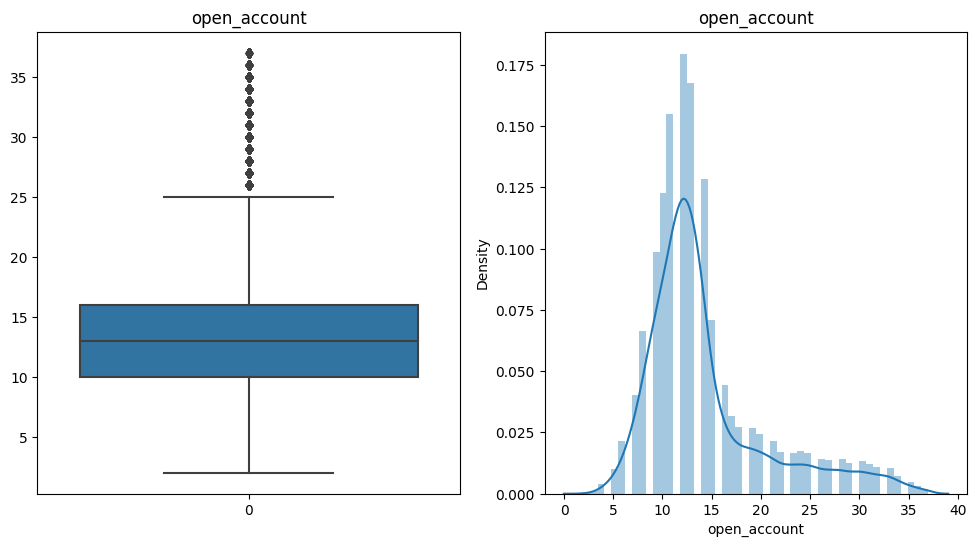

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'public_record')

<Axes: >

<ipython-input-163-1cc189c37dca>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)


<Axes: xlabel='public_record', ylabel='Density'>

Text(0.5, 1.0, 'public_record')

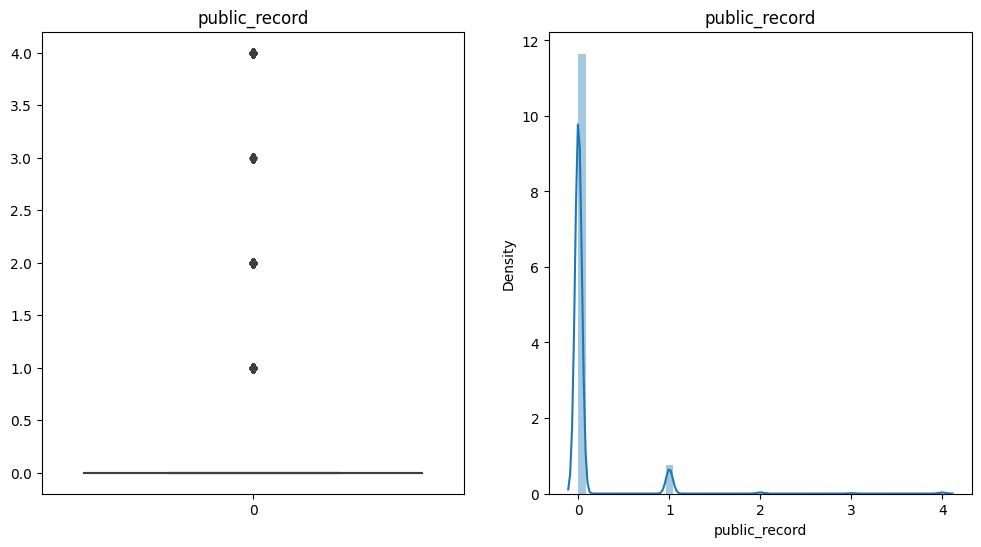

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'revolving_balance')

<Axes: >

<ipython-input-163-1cc189c37dca>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)


<Axes: xlabel='revolving_balance', ylabel='Density'>

Text(0.5, 1.0, 'revolving_balance')

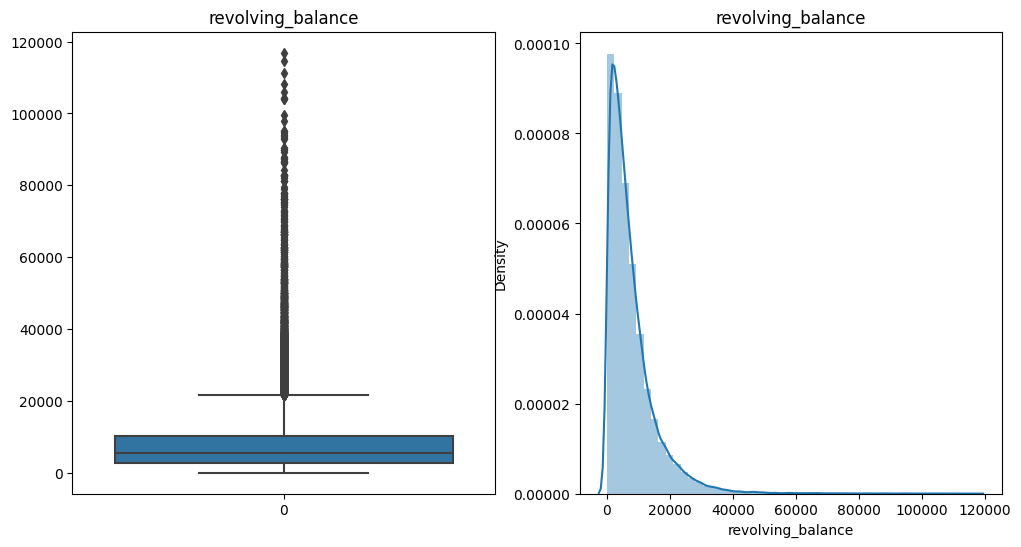

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'revolving_utilities')

<Axes: >

<ipython-input-163-1cc189c37dca>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)


<Axes: xlabel='revolving_utilities', ylabel='Density'>

Text(0.5, 1.0, 'revolving_utilities')

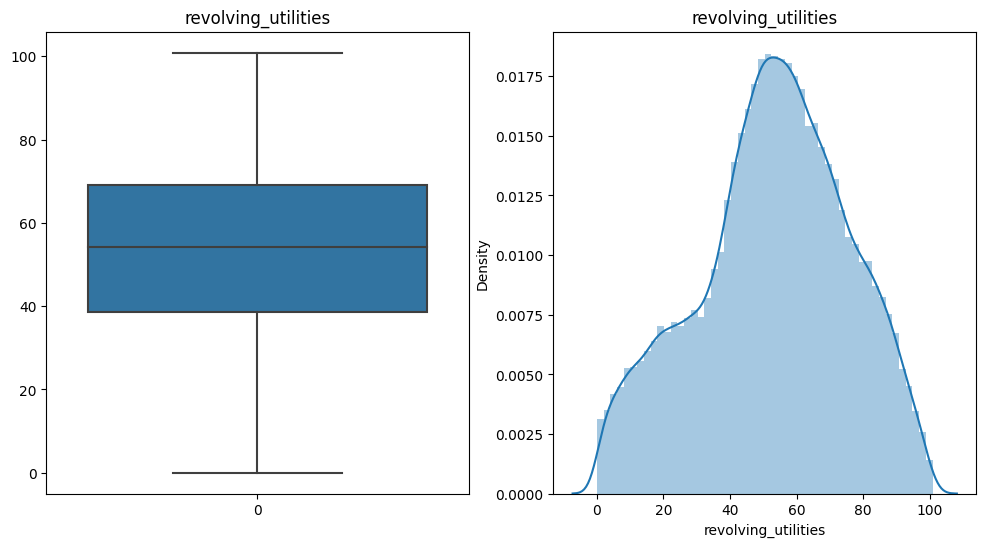

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'total_accounts')

<Axes: >

<ipython-input-163-1cc189c37dca>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)


<Axes: xlabel='total_accounts', ylabel='Density'>

Text(0.5, 1.0, 'total_accounts')

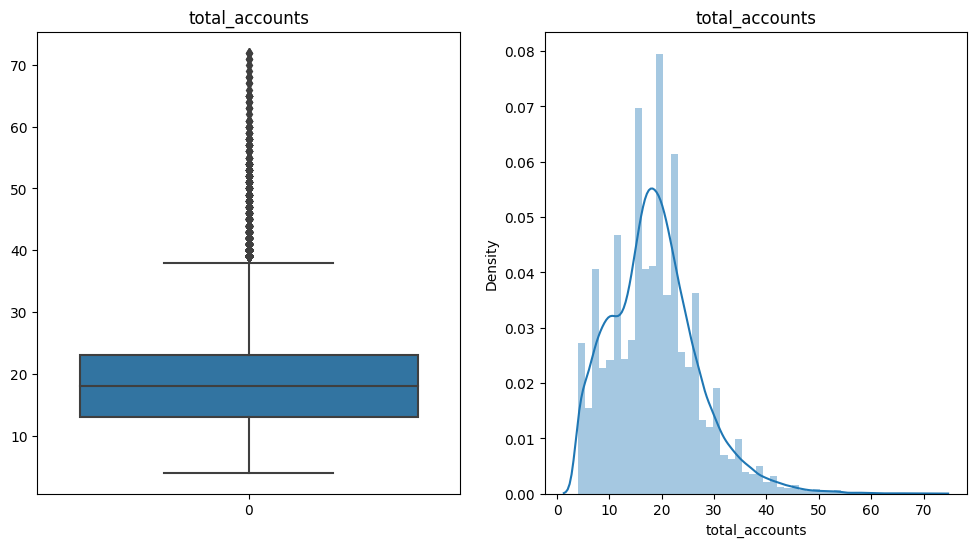

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'total_received_interest')

<Axes: >

<ipython-input-163-1cc189c37dca>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)


<Axes: xlabel='total_received_interest', ylabel='Density'>

Text(0.5, 1.0, 'total_received_interest')

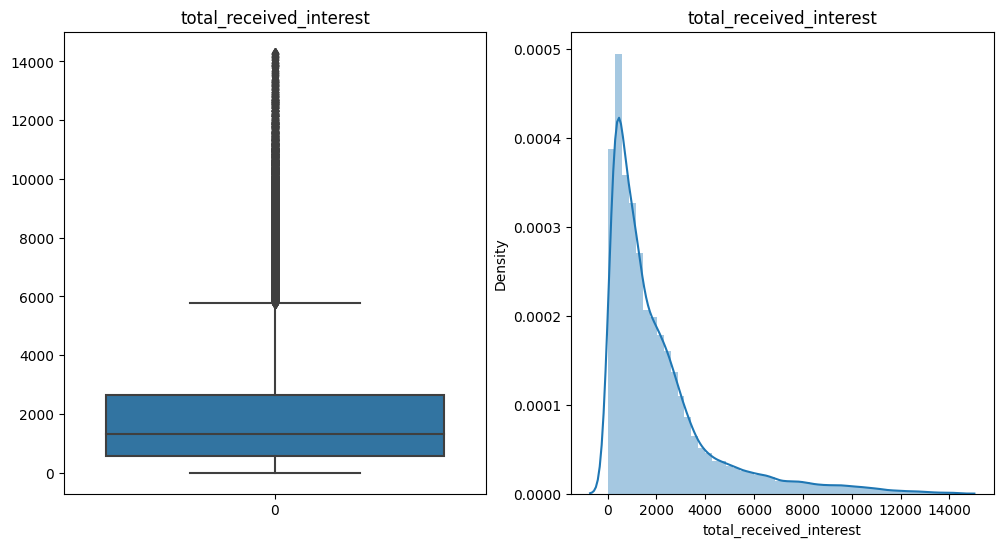

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'total_received_late_fee')

<Axes: >

<ipython-input-163-1cc189c37dca>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)


<Axes: xlabel='total_received_late_fee', ylabel='Density'>

Text(0.5, 1.0, 'total_received_late_fee')

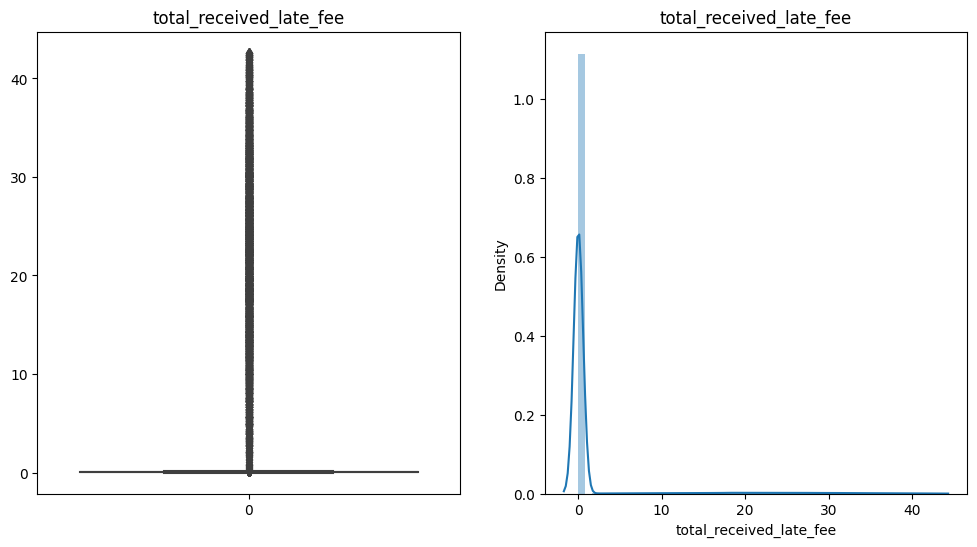

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'recoveries')

<Axes: >

<ipython-input-163-1cc189c37dca>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)


<Axes: xlabel='recoveries', ylabel='Density'>

Text(0.5, 1.0, 'recoveries')

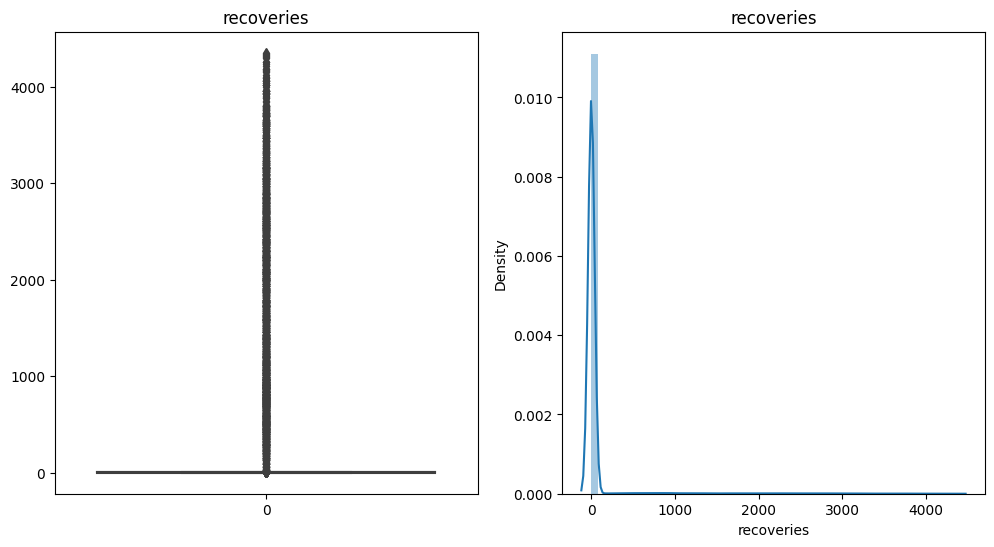

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'collection_recovery_fee')

<Axes: >

<ipython-input-163-1cc189c37dca>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)


<Axes: xlabel='collection_recovery_fee', ylabel='Density'>

Text(0.5, 1.0, 'collection_recovery_fee')

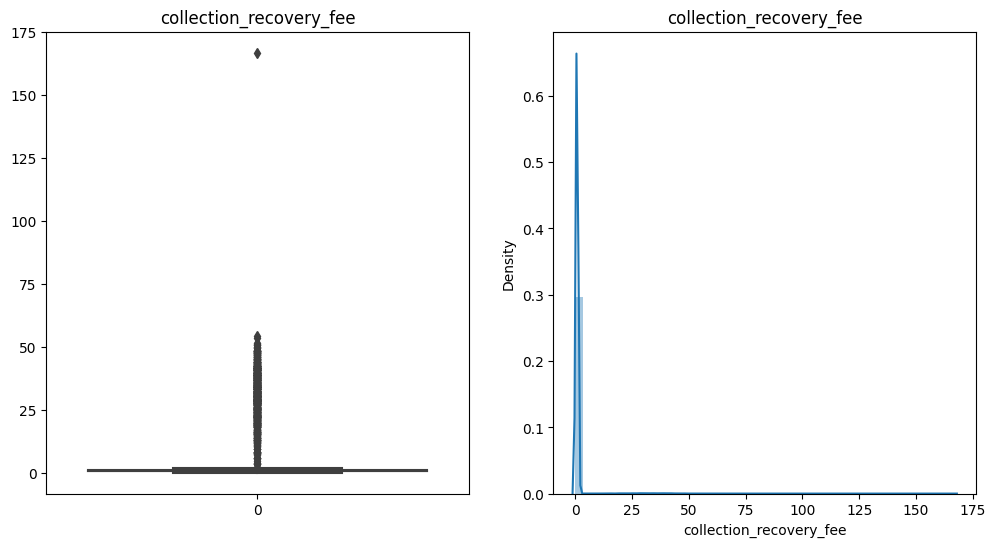

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'collection_12_months_medical')

<Axes: >

<ipython-input-163-1cc189c37dca>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)


<Axes: xlabel='collection_12_months_medical', ylabel='Density'>

Text(0.5, 1.0, 'collection_12_months_medical')

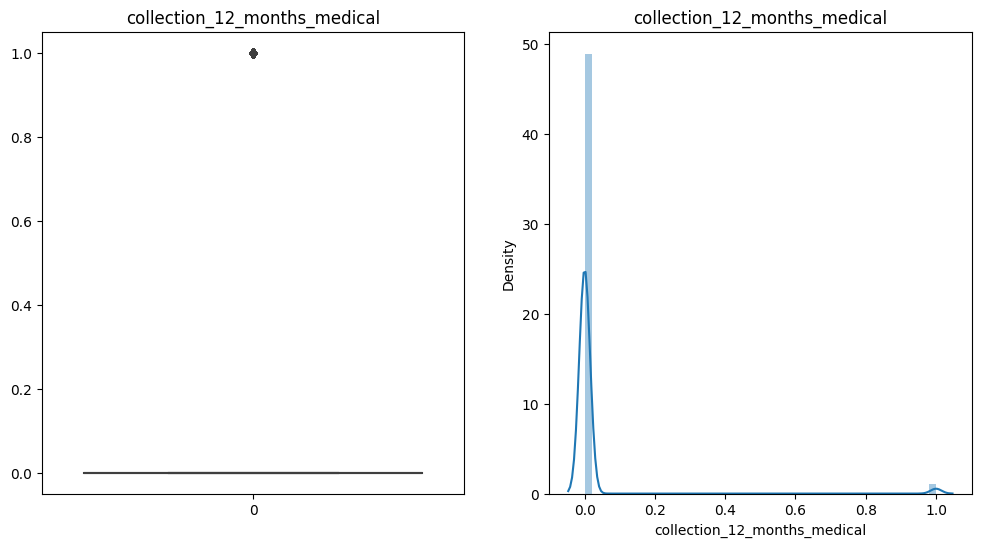

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'last_week_pay')

<Axes: >

<ipython-input-163-1cc189c37dca>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)


<Axes: xlabel='last_week_pay', ylabel='Density'>

Text(0.5, 1.0, 'last_week_pay')

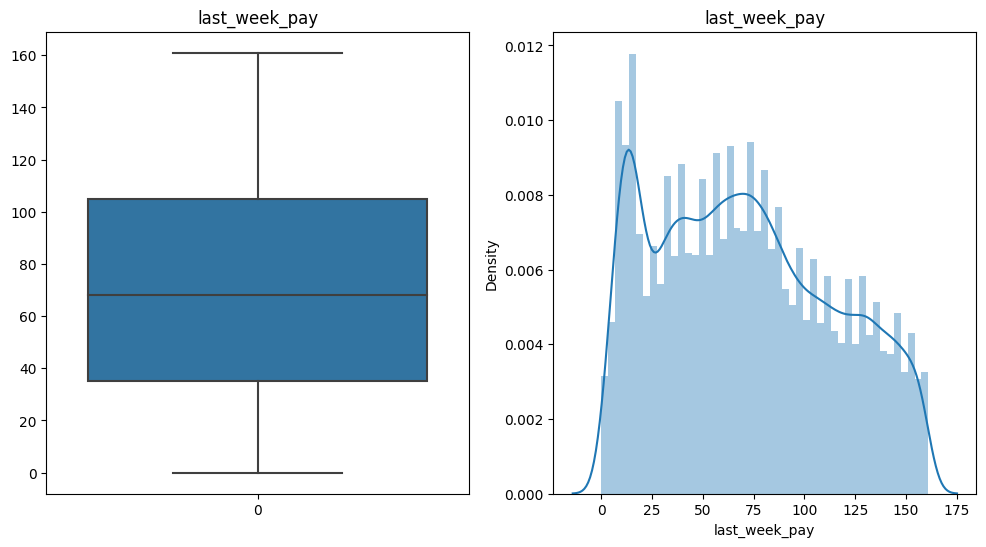

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'total_collection_amount')

<Axes: >

<ipython-input-163-1cc189c37dca>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)


<Axes: xlabel='total_collection_amount', ylabel='Density'>

Text(0.5, 1.0, 'total_collection_amount')

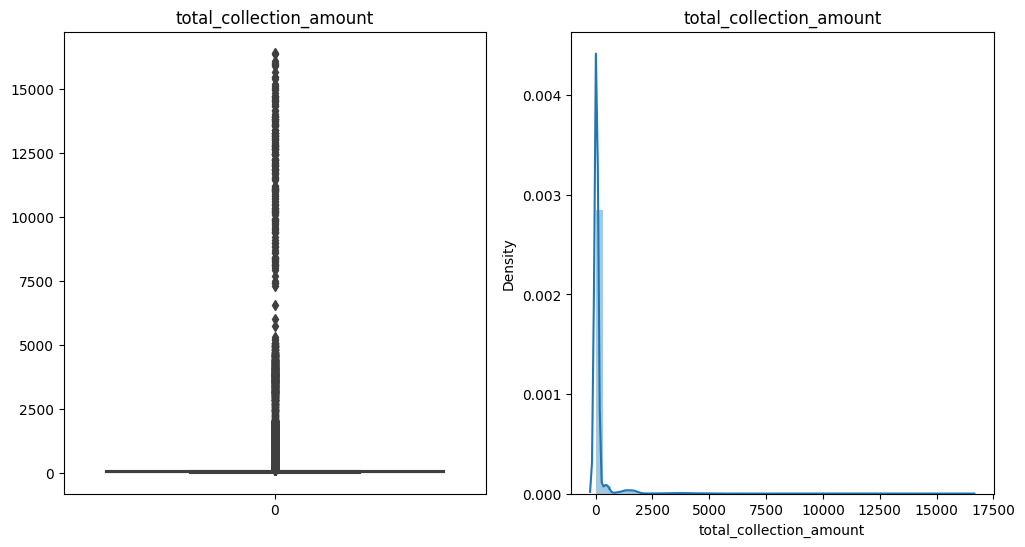

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'total_current_balance')

<Axes: >

<ipython-input-163-1cc189c37dca>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)


<Axes: xlabel='total_current_balance', ylabel='Density'>

Text(0.5, 1.0, 'total_current_balance')

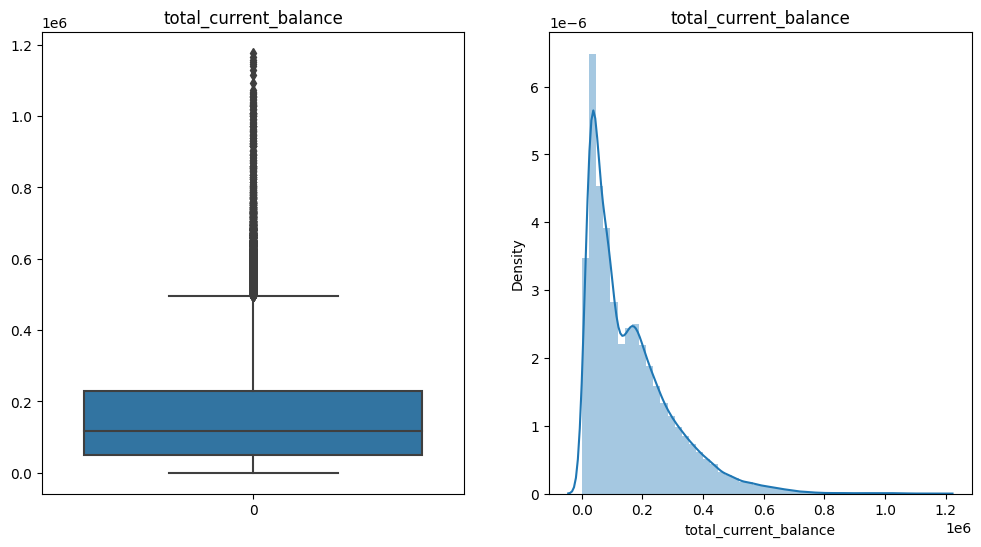

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'total_revolving_credit_limit')

<Axes: >

<ipython-input-163-1cc189c37dca>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)


<Axes: xlabel='total_revolving_credit_limit', ylabel='Density'>

Text(0.5, 1.0, 'total_revolving_credit_limit')

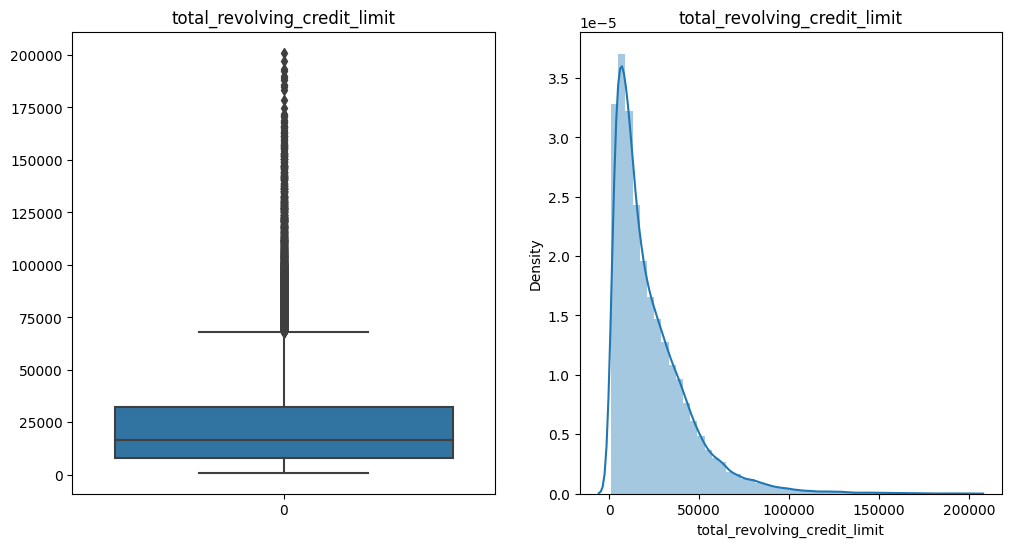

In [ ]:
## Outliers handling using Winsorizer IQR capping method
# iterate over the numeric columns in the DataFrame and plot a boxplot for each column
for col in df.drop(columns='loan_default_status').select_dtypes(exclude=['object']).columns:
    #fig, (ax1) = plt.subplots(1,2,1, figsize=(3,3))
      plt.figure(figsize=(12,6))
      plt.subplot(1,2,1)
      sns.boxplot(data=df[col])
      plt.title(col)

      plt.subplot(1,2,2)
      sns.distplot(df[col], kde=True)
      plt.title(col)
      plt.show()

<Figure size 600x600 with 0 Axes>

<Axes: xlabel='loan_default_status', ylabel='loan_amount'>

<Figure size 600x600 with 0 Axes>

<Axes: xlabel='loan_default_status', ylabel='funded_amount'>

<Figure size 600x600 with 0 Axes>

<Axes: xlabel='loan_default_status', ylabel='funded_amount_investor'>

<Figure size 600x600 with 0 Axes>

<Axes: xlabel='loan_default_status', ylabel='term'>

<Figure size 600x600 with 0 Axes>

<Axes: xlabel='loan_default_status', ylabel='interest_rate'>

<Figure size 600x600 with 0 Axes>

<Axes: xlabel='loan_default_status', ylabel='annual_income'>

<Figure size 600x600 with 0 Axes>

<Axes: xlabel='loan_default_status', ylabel='debit_to_income'>

<Figure size 600x600 with 0 Axes>

<Axes: xlabel='loan_default_status', ylabel='delinquency_-_two_years'>

<Figure size 600x600 with 0 Axes>

<Axes: xlabel='loan_default_status', ylabel='inquires_-_six_months'>

<Figure size 600x600 with 0 Axes>

<Axes: xlabel='loan_default_status', ylabel='open_account'>

<Figure size 600x600 with 0 Axes>

<Axes: xlabel='loan_default_status', ylabel='public_record'>

<Figure size 600x600 with 0 Axes>

<Axes: xlabel='loan_default_status', ylabel='revolving_balance'>

<Figure size 600x600 with 0 Axes>

<Axes: xlabel='loan_default_status', ylabel='revolving_utilities'>

<Figure size 600x600 with 0 Axes>

<Axes: xlabel='loan_default_status', ylabel='total_accounts'>

<Figure size 600x600 with 0 Axes>

<Axes: xlabel='loan_default_status', ylabel='total_received_interest'>

<Figure size 600x600 with 0 Axes>

<Axes: xlabel='loan_default_status', ylabel='total_received_late_fee'>

<Figure size 600x600 with 0 Axes>

<Axes: xlabel='loan_default_status', ylabel='recoveries'>

<Figure size 600x600 with 0 Axes>

<Axes: xlabel='loan_default_status', ylabel='collection_recovery_fee'>

<Figure size 600x600 with 0 Axes>

<Axes: xlabel='loan_default_status', ylabel='collection_12_months_medical'>

<Figure size 600x600 with 0 Axes>

<Axes: xlabel='loan_default_status', ylabel='last_week_pay'>

<ipython-input-13-2d26e328c253>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6,6))


<Figure size 600x600 with 0 Axes>

<Axes: xlabel='loan_default_status', ylabel='total_collection_amount'>

<Figure size 600x600 with 0 Axes>

<Axes: xlabel='loan_default_status', ylabel='total_current_balance'>

<Figure size 600x600 with 0 Axes>

<Axes: xlabel='loan_default_status', ylabel='total_revolving_credit_limit'>

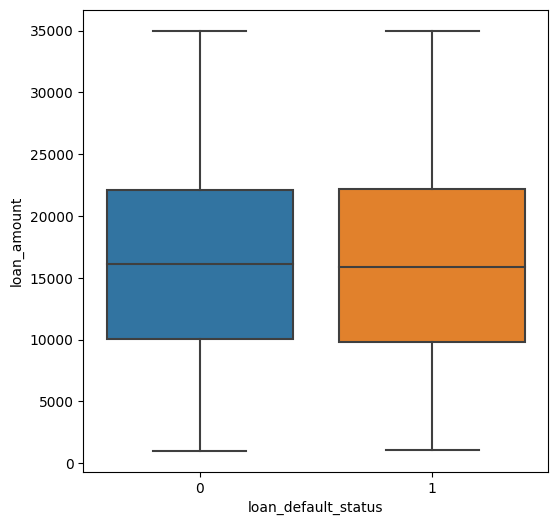

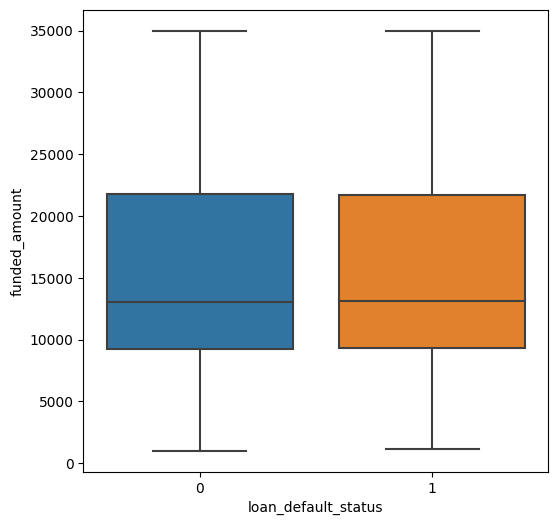

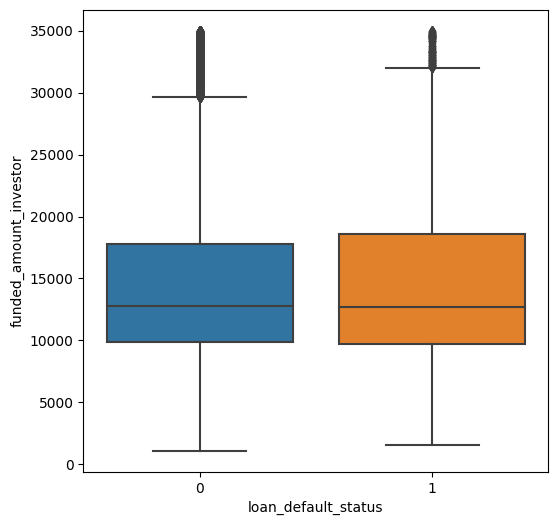

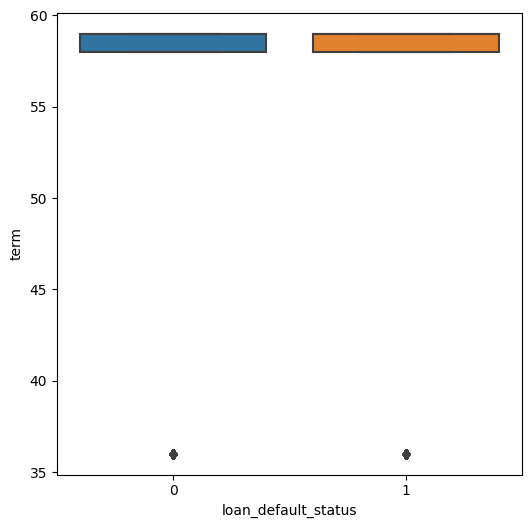

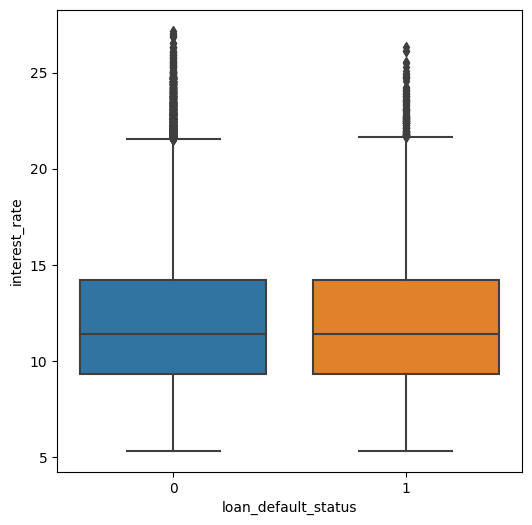

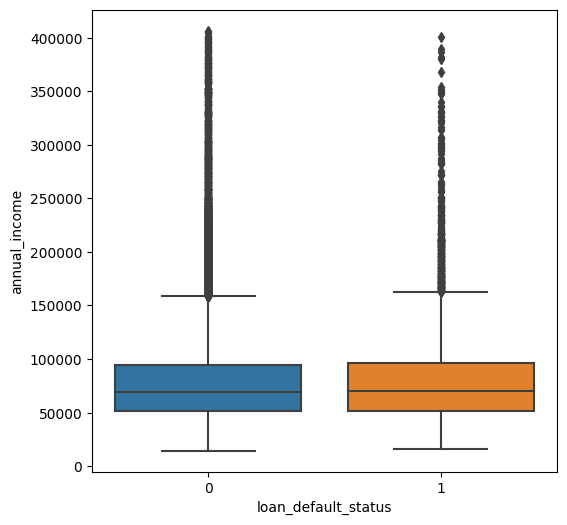

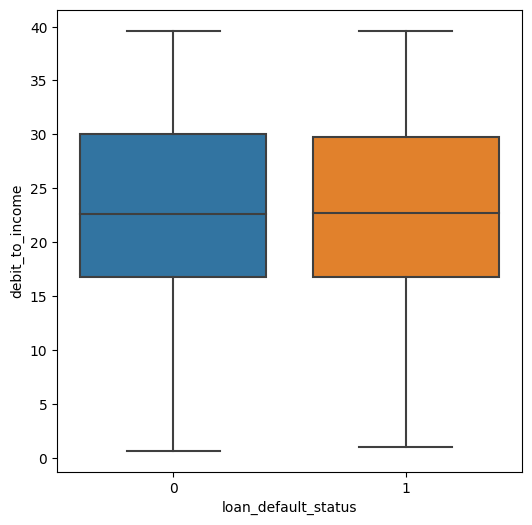

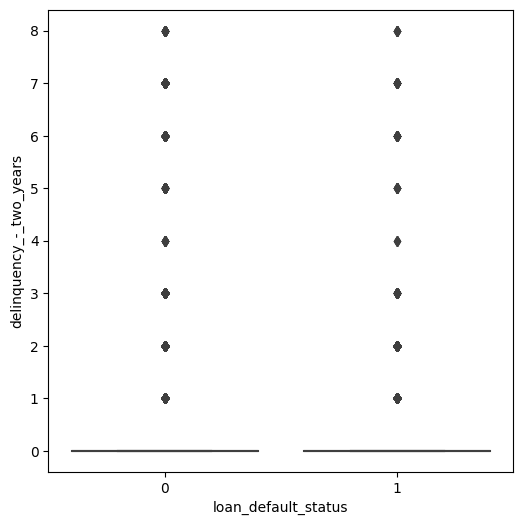

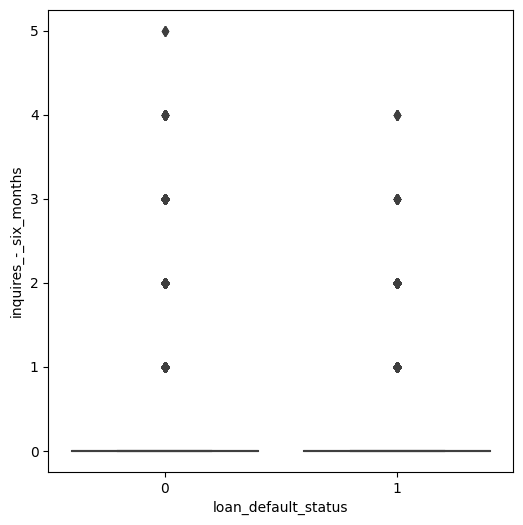

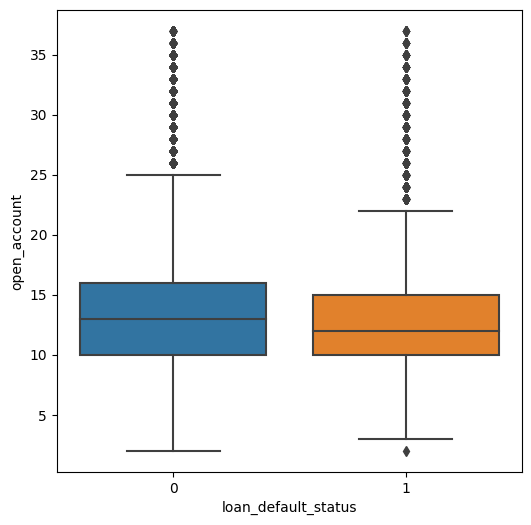

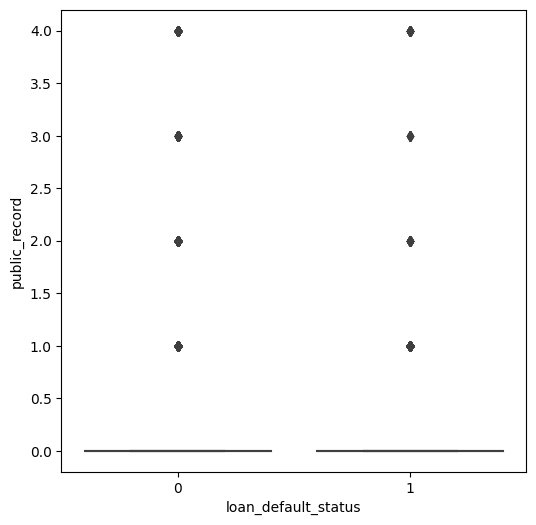

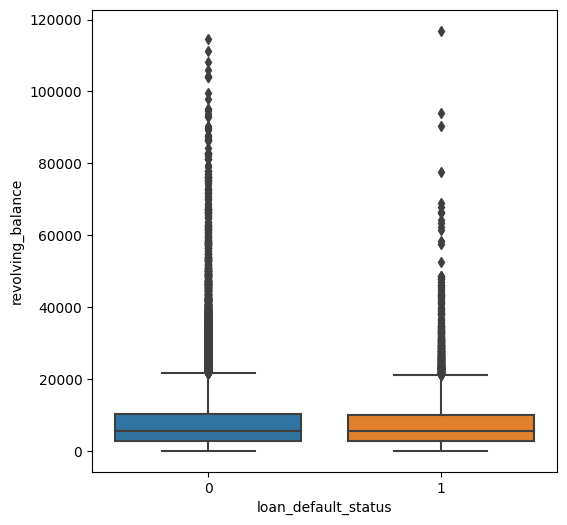

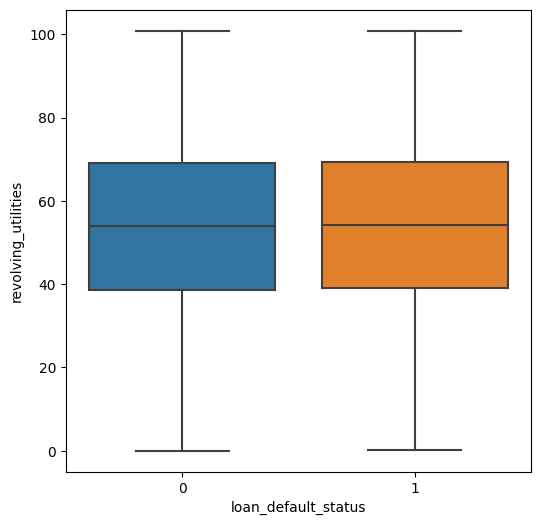

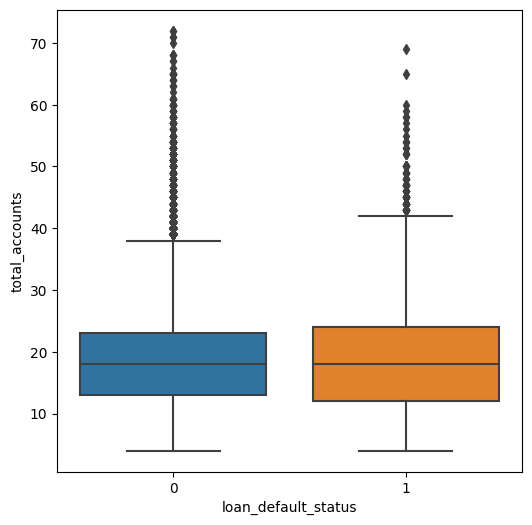

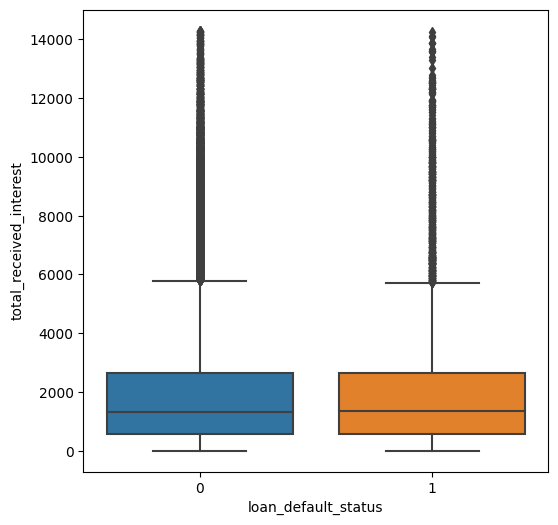

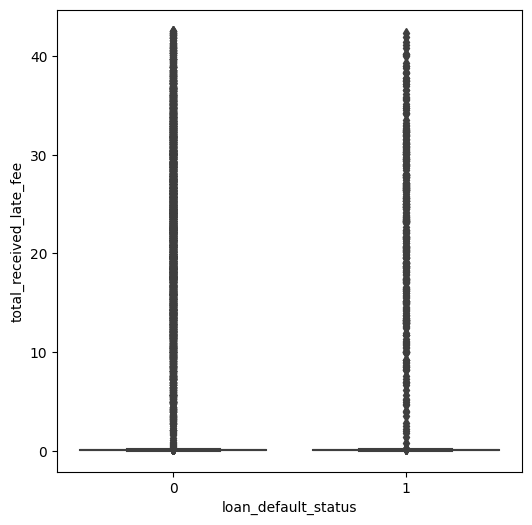

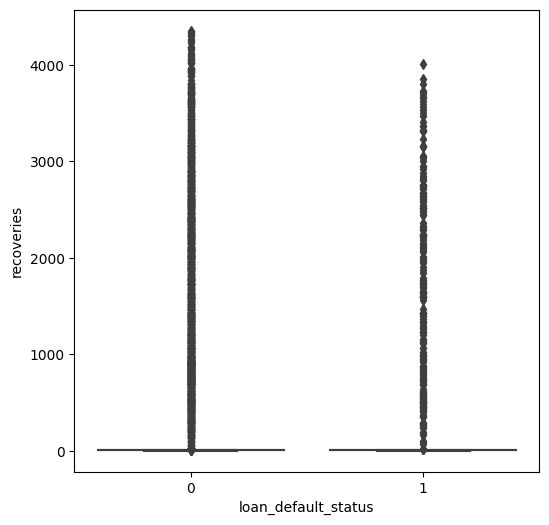

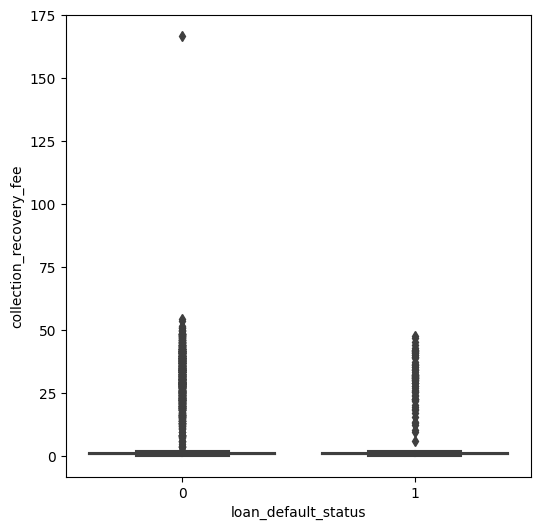

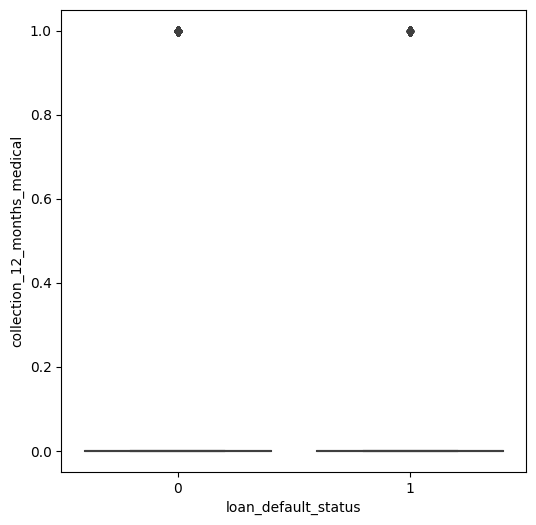

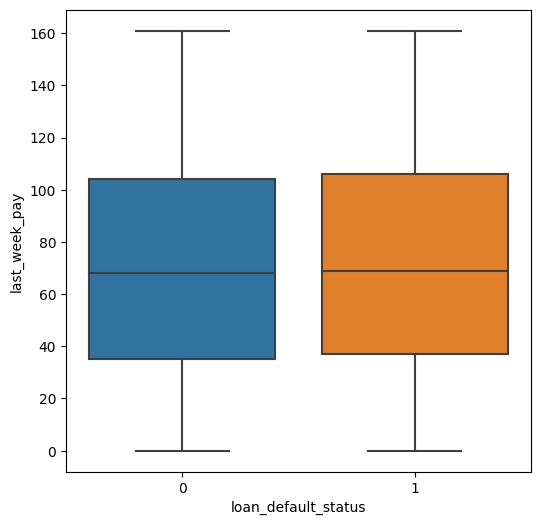

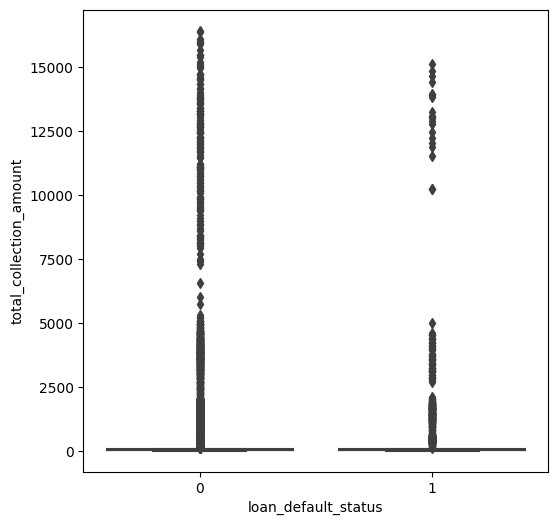

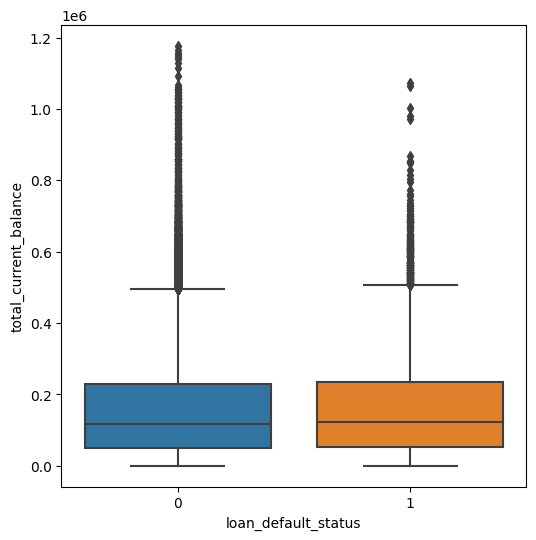

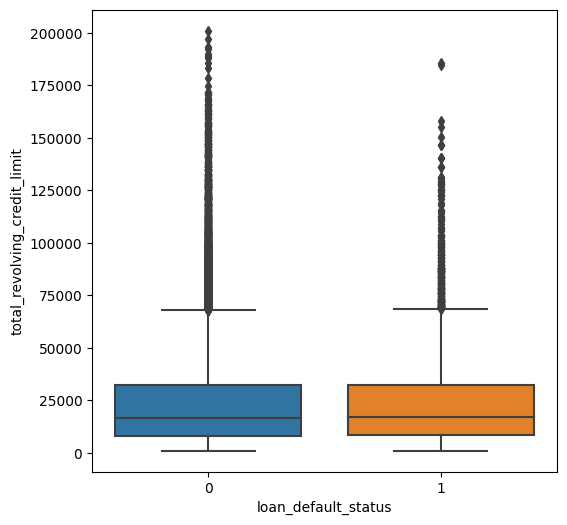

In [ ]:
for col in df.drop(columns='loan_default_status').select_dtypes(exclude=['object']).columns:
  plt.figure(figsize=(6,6))
  sns.boxplot(x='loan_default_status', y=col, data=df)

In [ ]:
capper = Winsorizer(capping_method='iqr',
                    tail='both',
                    fold=3,
                    variables=['funded_amount_investor', 'interest_rate',
                               'annual_income', 'open_account', 'total_accounts',
                               'revolving_balance','total_received_interest','total_current_balance',
                               'total_revolving_credit_limit'])
capper.fit(df)
print(capper.right_tail_caps_)
print(capper.left_tail_caps_)
# transform the data
df = capper.transform(df)
df.head(10)

<Axes: >

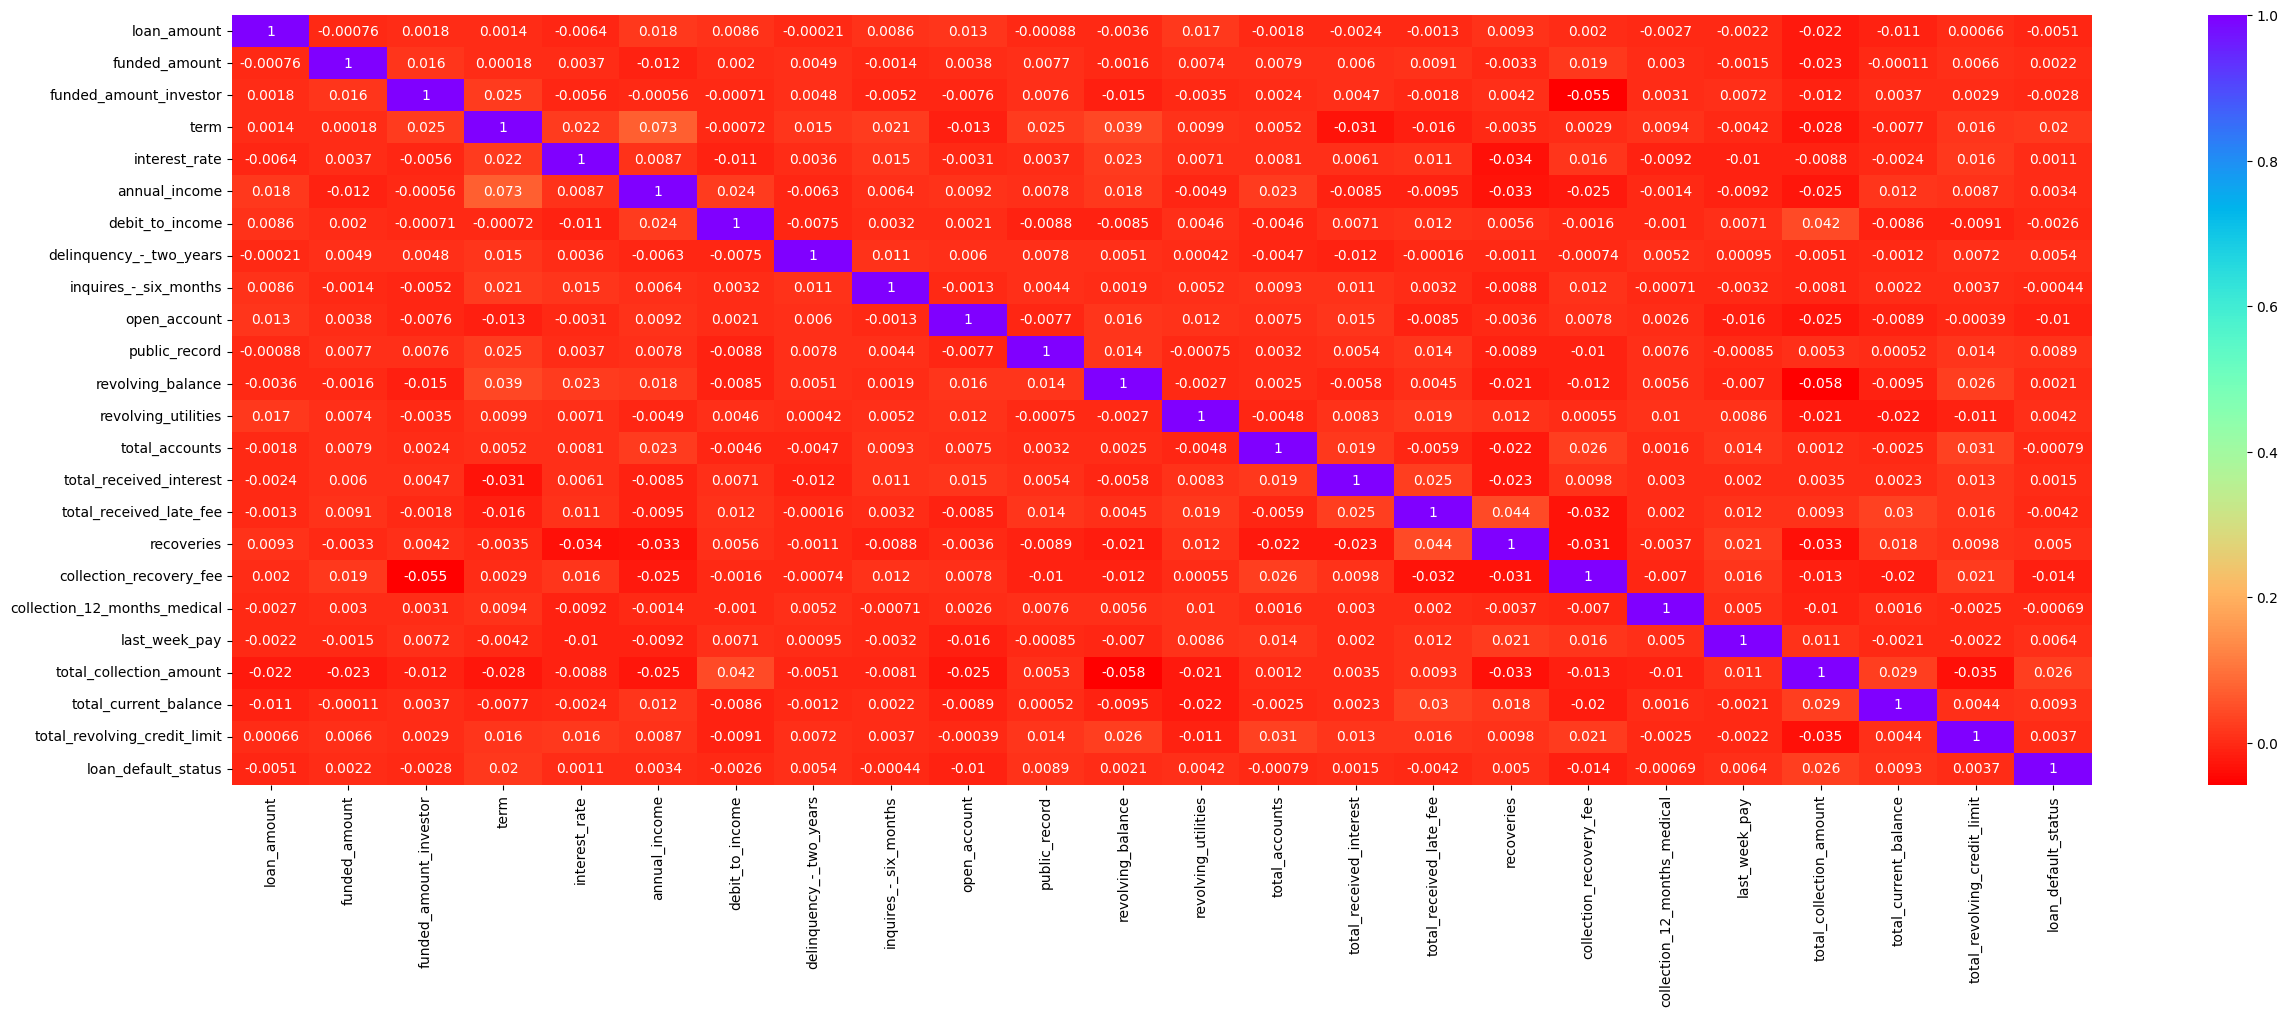

In [ ]:
# correlation between y and features
##sns.set(rc={'figure.figsize':(30,10)})
#sns.set_context("talk", font_scale=0.7)
fig, ax = plt.subplots(figsize=(30, 10))
sns.heatmap(df.iloc[:].corr(method='spearman'), cmap='rainbow_r', annot=True)

<Axes: >

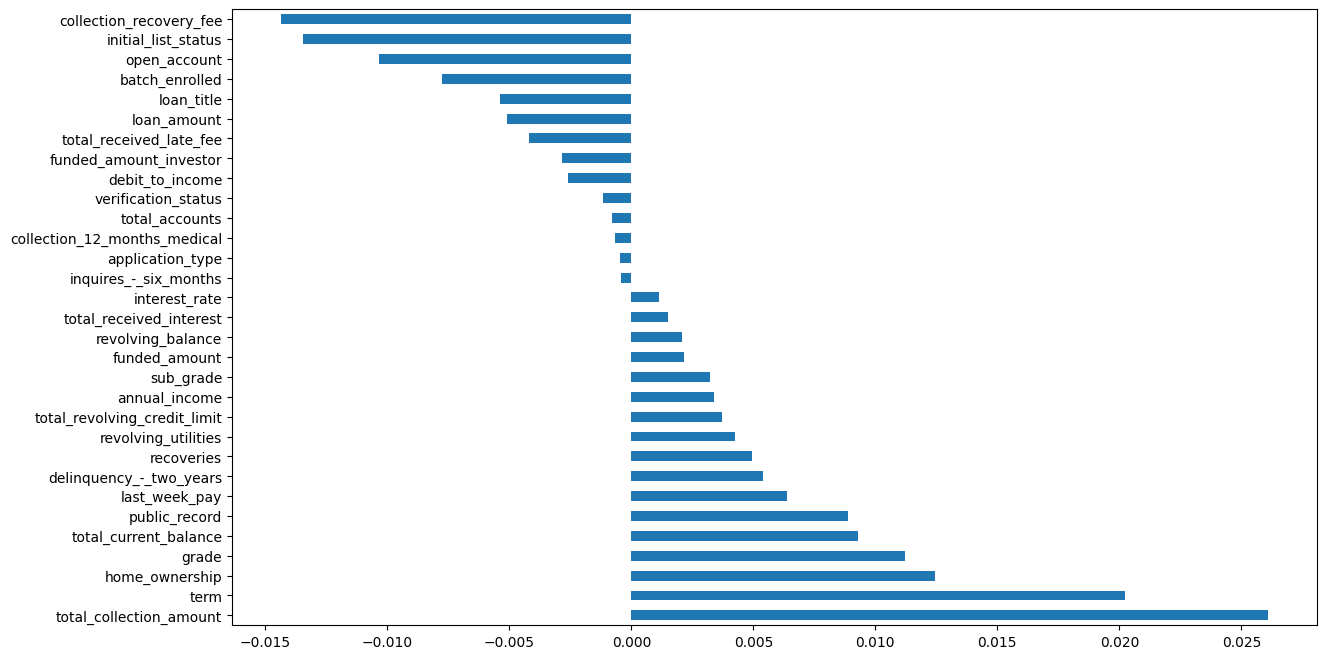

In [ ]:
df.drop("loan_default_status", axis=1).apply(lambda x: x.corr(df.loan_default_status,method='spearman')).sort_values(ascending=False).plot(kind='barh', figsize=(14,8))

In [ ]:
#distribution of the target. There is data imbalance
# Resample is required
df.loan_default_status.value_counts().reset_index()

index  loan_default_status
0      0                61222
1      1                 6241

In [ ]:
# Rebalancing is required as bias toward Non-Defaulters
(6241/(6241+61222))*100

9.250996842713784

<Axes: title={'center': 'Target  Balance'}, xlabel='loan_status', ylabel='Relative Frequency'>

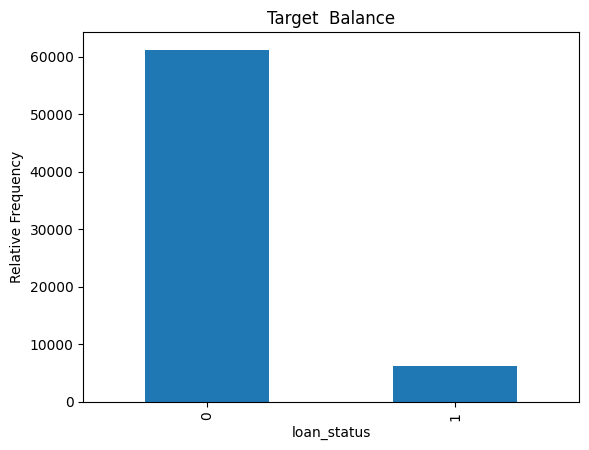

In [ ]:
df["loan_default_status"].value_counts(normalize=False).plot(
    kind="bar", xlabel="loan_status", ylabel="Relative Frequency", title="Target  Balance"
)

In [ ]:
global_loan_default_status_mean = df.loan_default_status.mean()
global_loan_default_status_mean

0.09250996842713784

## Feature Importance/Selection based on Risk Ratio

In [ ]:
#Mutual Information - https://triveratechvirtual6x.my.webex.com/recordingservice/sites/triveratechvirtual6x.my/recording/ccb27c09288d103cbbfdf2d7f7787d99/playback
# Does Category mean vary widely from global mean?

for col in df.select_dtypes(include='object').columns:
    df_group = df.groupby(by=col).loan_default_status.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_loan_default_status_mean

    #Risk Ratio. Higher risk to default if ratio is significantly >1
    df_group['risk'] = df_group['mean'] / global_loan_default_status_mean
    df_group['count'] = df[col].value_counts()
    display(df_group)

mean      diff      risk  count
batch_enrolled                                     
bat1104812      0.099800  0.007290  1.078800   2996
bat1135695      0.125000  0.032490  1.351206    296
bat1184694      0.083551 -0.008959  0.903156   2298
bat1467036      0.091022 -0.001488  0.983920    802
bat1586599      0.105029  0.012519  1.135322   3142
bat1761981      0.104027  0.011517  1.124493    894
bat1766061      0.084873 -0.007637  0.917451   1461
bat1780517      0.099459  0.006949  1.075117   2403
bat1930365      0.094902  0.002392  1.025861   1844
bat2003848      0.108076  0.015566  1.168263    842
bat2078974      0.091266 -0.001244  0.986557   2290
bat2136391      0.092179 -0.000331  0.996420   1790
bat224923       0.099441  0.006931  1.074926    895
bat2252229      0.093078  0.000568  1.006138   2557
bat2333412      0.085634 -0.006876  0.925671   1775
bat2428731      0.092275 -0.000235  0.997457   1398
bat2522922      0.095068  0.002558  1.027650   1399
bat2558388      0.095772  0.003262  1.035259   1963
bat2575549      0.094373  0.001863  1.020139   2257
bat2803411      0.088247 -0.004263  0.953923   2425
bat2833642      0.086559 -0.005951  0.935670   1421
bat3193689      0.087446 -0.005064  0.945264   1864
bat3461431      0.084270 -0.008240  0.910925   1068
bat3726927      0.078354 -0.014156  0.846979   1774
bat3865626      0.078297 -0.014213  0.846360    728
bat3873588      0.093767  0.001257  1.013591   3626
bat4136152      0.083805 -0.008705  0.905905   1766
bat4271519      0.094450  0.001940  1.020969   2054
bat4351734      0.094737  0.002227  1.024072   1140
bat4694572      0.096085  0.003575  1.038649   2248
bat4722912      0.096956  0.004446  1.048060    887
bat4808022      0.099770  0.007260  1.078476   1303
bat5341619      0.087944 -0.004566  0.950644   1717
bat5489674      0.084079 -0.008431  0.908861   1677
bat5525466      0.091867 -0.000643  0.993045   1709
bat5547201      0.097604  0.005094  1.055067   1127
bat5629144      0.098231  0.005721  1.061838   1639
bat5714674      0.084163 -0.008347  0.909771   1105
bat5811547      0.094233  0.001724  1.018630    711
bat5849876      0.093750  0.001240  1.013404    768
bat5924421      0.079772 -0.012738  0.862308   1404

mean      diff      risk  count
grade                                     
a      0.091248 -0.001262  0.986363  12055
b      0.087237 -0.005273  0.943003  18742
c      0.093896  0.001386  1.014980  19085
d      0.096380  0.003870  1.041831   8259
e      0.095873  0.003363  1.036358   6446
f      0.103740  0.011230  1.121392   2246
g      0.106349  0.013839  1.149597    630

mean      diff      risk  count
sub_grade                                     
a1         0.091642 -0.000868  0.990620   1364
a2         0.097986  0.005476  1.059192   1837
a3         0.094362  0.001852  1.020020   1685
a4         0.091431 -0.001079  0.988338   2264
a5         0.094068  0.001558  1.016840   3540
b1         0.099863  0.007353  1.079486   2924
b2         0.088920 -0.003590  0.961199   3520
b3         0.082521 -0.009989  0.892019   3999
b4         0.091887 -0.000623  0.993266   4462
b5         0.095657  0.003147  1.034021   3408
c1         0.078558 -0.013952  0.849182   4188
c2         0.094129  0.001619  1.017497   3219
c3         0.094201  0.001691  1.018275   3121
c4         0.093538  0.001028  1.011118   3250
c5         0.095874  0.003364  1.036362   2472
d1         0.093523  0.001013  1.010951   3304
d2         0.097809  0.005300  1.057286   1963
d3         0.089912 -0.002598  0.971920   1824
d4         0.090244 -0.002266  0.975505   2050
d5         0.103484  0.010974  1.118621   1952
e1         0.100924  0.008415  1.090958   1298
e2         0.088774 -0.003736  0.959619   1746
e3         0.089326 -0.003184  0.965585   1321
e4         0.102059  0.009549  1.103223   1117
e5         0.080624 -0.011886  0.871519    769
f1         0.087379 -0.005131  0.944532    824
f2         0.100317  0.007807  1.084389    947
f3         0.098616  0.006106  1.066003    578
f4         0.099773  0.007263  1.078513    441
f5         0.091065 -0.001445  0.984384    582
g1         0.095628  0.003118  1.033709    366
g2         0.080537 -0.011973  0.870576    447
g3         0.130081  0.037571  1.406133    246
g4         0.099338  0.006828  1.073806    151
g5         0.098592  0.006082  1.065740    284

mean      diff      risk  count
home_ownership                                     
mortgage        0.088663 -0.003847  0.958419  36351
own             0.101551  0.009041  1.097733   6962
rent            0.095694  0.003184  1.034414  24150

mean      diff      risk  count
verification_status                                     
not_verified         0.092116 -0.000394  0.995738  16349
source_verified      0.093383  0.000873  1.009437  33036
verified             0.091271 -0.001239  0.986609  18078

mean      diff      risk  count
loan_title                                                     
bathroom                    0.071429 -0.021081  0.772118     14
bill_consolidation          0.066667 -0.025843  0.720643     15
bill_payoff                 0.250000  0.157490  2.702411     12
bills                       0.500000  0.407490  5.404823      4
business                    0.076503 -0.016007  0.826967    183
car_financing               0.140741  0.048231  1.521358    135
car_loan                    0.000000 -0.092510  0.000000      9
card_consolidation          0.062500 -0.030010  0.675603     16
cards                       0.142857  0.050347  1.544235     28
cc                          0.000000 -0.092510  0.000000      6
cc-refinance                0.000000 -0.092510  0.000000     13
cc_consolidation            0.125000  0.032490  1.351206     32
cc_loan                     0.153846  0.061336  1.663022     13
cc_refi                     0.250000  0.157490  2.702411     12
cc_refinance                0.066667 -0.025843  0.720643     15
conso                       0.100000  0.007490  1.080965     10
consolidate                 0.075472 -0.017038  0.815822    106
consolidated                0.000000 -0.092510  0.000000     13
consolidation               0.089172 -0.003338  0.963917    157
consolidation_loan          0.113636  0.021126  1.228369     88
credit                      0.000000 -0.092510  0.000000      4
credit_card                 0.107143  0.014633  1.158176     56
credit_card_consolidation   0.119565  0.027055  1.292458     92
credit_card_debt            0.111111  0.018601  1.201072     45
credit_card_loan            0.266667  0.174157  2.882572     30
credit_card_pay_off         0.181818  0.089308  1.965390     11
credit_card_paydown         0.000000 -0.092510  0.000000      9
credit_card_payoff          0.119403  0.026893  1.290704     67
credit_card_refi            0.166667  0.074157  1.801608     12
credit_card_refinance       0.082353 -0.010157  0.890206     85
credit_card_refinance_loan  0.166667  0.074157  1.801608      6
credit_card_refinancing     0.093986  0.001476  1.015955  30728
credit_cards                0.093750  0.001240  1.013404     32
credit_consolidation        0.120000  0.027490  1.297158     25
credit_loan                 0.000000 -0.092510  0.000000     10
credit_pay_off              0.000000 -0.092510  0.000000      9
credit_payoff               0.125000  0.032490  1.351206     16
debt                        0.117647  0.025137  1.271723     51
debt_consolidation          0.089606 -0.002904  0.968610  28536
debt_consolidation_2013     0.000000 -0.092510  0.000000      6
debt_consolidation_loan     0.083333 -0.009177  0.900804     96
debt_free                   0.045455 -0.047055  0.491348     22
debt_loan                   0.081081 -0.011429  0.876458     37
debt_payoff                 0.241379  0.148869  2.609225     29
debt_reduction              0.153846  0.061336  1.663022     13
dept_consolidation          0.142857  0.050347  1.544235     14
freedom                     0.066667 -0.025843  0.720643     45
get_debt_free               0.153846  0.061336  1.663022     13
get_out_of_debt             0.166667  0.074157  1.801608     12
getting_ahead               0.200000  0.107490  2.161929      5
green_loan                  0.088889 -0.003621  0.960857     45
home                        0.076923 -0.015587  0.831511     13
home_buying                 0.159574  0.067064  1.724943     94
home_improvement            0.094159  0.001649  1.017822   2294
home_improvement_loan       0.153846  0.061336  1.663022     13
home_loan                   0.166667  0.074157  1.801608      6
house                       0.125000  0.032490  1.351206     16
lending_club                0.031250 -0.061260  0.337801     32
lending_loan                0.153846  0.061336  1.663022     13
loan                        0.088235 -0.004275  0.953792     34
loan1                       0.076923 -0.015587  0.831511     13


mean      diff      risk  count
initial_list_status                                     
f                    0.096714  0.004204  1.045446  31164
w                    0.088901 -0.003609  0.960983  36299

mean      diff      risk  count
application_type                                     
individual        0.092516  0.000006  1.000061  67340
joint             0.089431 -0.003079  0.966716    123

In [ ]:
#Following features can be dropped based on Risk Ratio
# initial_list_status, application_type, verification_status
df.drop(columns=['initial_list_status','application_type','verification_status'], axis=1, inplace=True)
df.head(5).T

0                   1  \
loan_amount                                10000                3609   
funded_amount                              32236               11940   
funded_amount_investor               12329.36286         12191.99692   
term                                          59                  59   
batch_enrolled                        bat2522922          bat1586599   
interest_rate                          11.135007           12.237563   
grade                                          b                   c   
sub_grade                                     c4                  d3   
home_ownership                          mortgage                rent   
annual_income                        176346.6267           39833.921   
loan_title                    debt_consolidation  debt_consolidation   
debit_to_income                        16.284758           15.412409   
delinquency_-_two_years                        1                   0   
inquires_-_six_months                          0                   0   
open_account                                  13                  12   
public_record                                  0                   0   
revolving_balance                          24246                 812   
revolving_utilities                    74.932551           78.297186   
total_accounts                                 7                  13   
total_received_interest              2929.646315          772.769385   
total_received_late_fee                 0.102055            0.036181   
recoveries                              2.498291            2.377215   
collection_recovery_fee                 0.793724            0.974821   
collection_12_months_medical                   0                   0   
last_week_pay                                 49                 109   
total_collection_amount                       31                  53   
total_current_balance                     311301              182610   
total_revolving_credit_limit                6619               20885   
loan_default_status                            0                   0   

                                               2                   3  \
loan_amount                                28276               11170   
funded_amount                               9311                6954   
funded_amount_investor               21603.22455         17877.15585   
term                                          59                  59   
batch_enrolled                        bat2136391          bat2428731   
interest_rate                          12.545884           16.731201   
grade                                          f                   c   
sub_grade                                     d4                  c3   
home_ownership                          mortgage            mortgage   
annual_income                        91506.69105         108286.5759   
loan_title                    debt_consolidation  debt_consolidation   
debit_to_income                        28.137619            18.04373   
delinquency_-_two_years                        0                   1   
inquires_-_six_months                          0                   0   
open_account                                  14                   7   
public_record                                  0                   0   
revolving_balance                           1843               13819   
revolving_utilities                      2.07304           67.467951   
total_accounts                                20                  12   
total_received_interest               863.324396          288.173196   
total_received_late_fee                 18.77866            0.044131   
recoveries                              4.316277             0.10702   
collection_recovery_fee                 1.020075            0.749971   
collection_12_months_medical                   0                   0   
last_week_pay                                 66                  39   
total_collecti

In [ ]:
# Select object type data and numerical data columns seperately
cate = [i for i in df.select_dtypes(include='object').columns]
num = [i for i in df.select_dtypes(exclude='object').columns]
print(cate)
print(num)

['batch_enrolled', 'grade', 'sub_grade', 'home_ownership', 'loan_title']
['loan_amount', 'funded_amount', 'funded_amount_investor', 'term', 'interest_rate', 'annual_income', 'debit_to_income', 'delinquency_-_two_years', 'inquires_-_six_months', 'open_account', 'public_record', 'revolving_balance', 'revolving_utilities', 'total_accounts', 'total_received_interest', 'total_received_late_fee', 'recoveries', 'collection_recovery_fee', 'collection_12_months_medical', 'last_week_pay', 'total_collection_amount', 'total_current_balance', 'total_revolving_credit_limit', 'loan_default_status']


In [ ]:
#Categorical unique values
df[cate].nunique()

batch_enrolled    41
grade              7
sub_grade         35
home_ownership     3
loan_title        83
dtype: int64

## Feature Engineering transformation

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67463 entries, 0 to 67462
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   loan_amount                   67463 non-null  int64  
 1   funded_amount                 67463 non-null  int64  
 2   funded_amount_investor        67463 non-null  float64
 3   term                          67463 non-null  int64  
 4   batch_enrolled                67463 non-null  object 
 5   interest_rate                 67463 non-null  float64
 6   grade                         67463 non-null  object 
 7   sub_grade                     67463 non-null  object 
 8   home_ownership                67463 non-null  object 
 9   annual_income                 67463 non-null  float64
 10  loan_title                    67463 non-null  object 
 11  debit_to_income               67463 non-null  float64
 12  delinquency_-_two_years       67463 non-null  int64  
 13  i

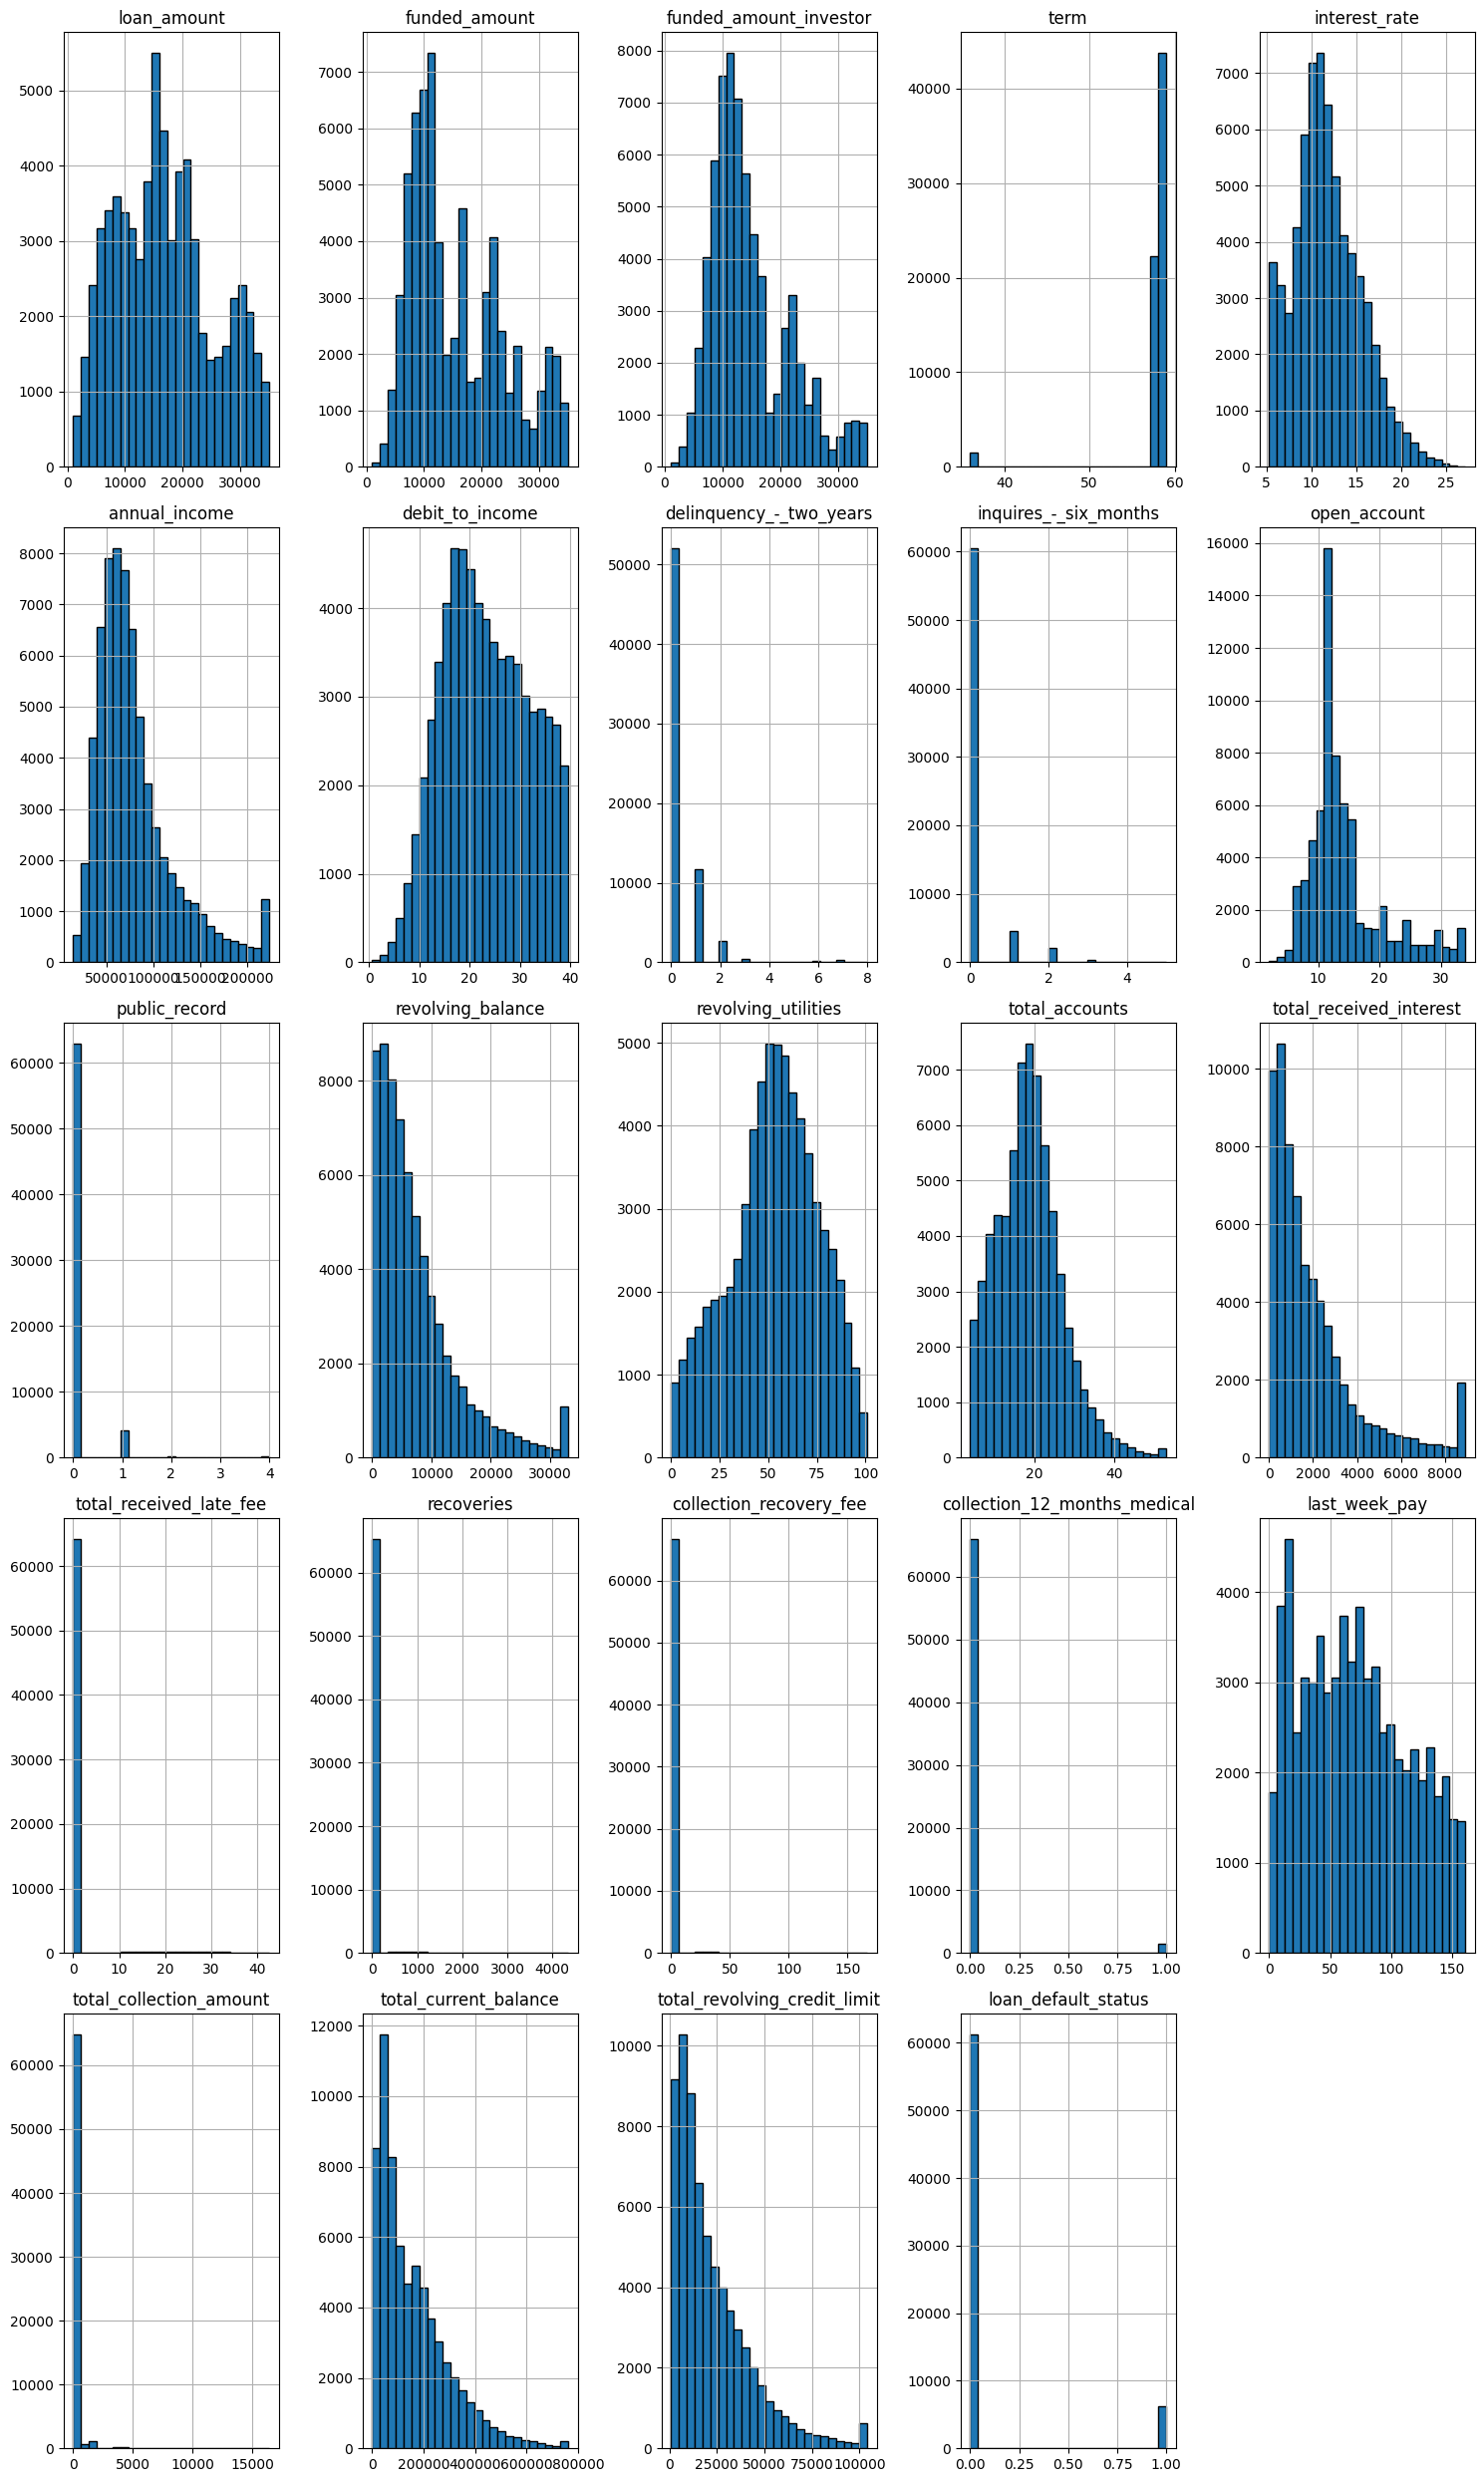

In [ ]:
df.hist(bins=25, figsize=(15, 25), layout=(-1, 5), edgecolor="black")
plt.tight_layout();

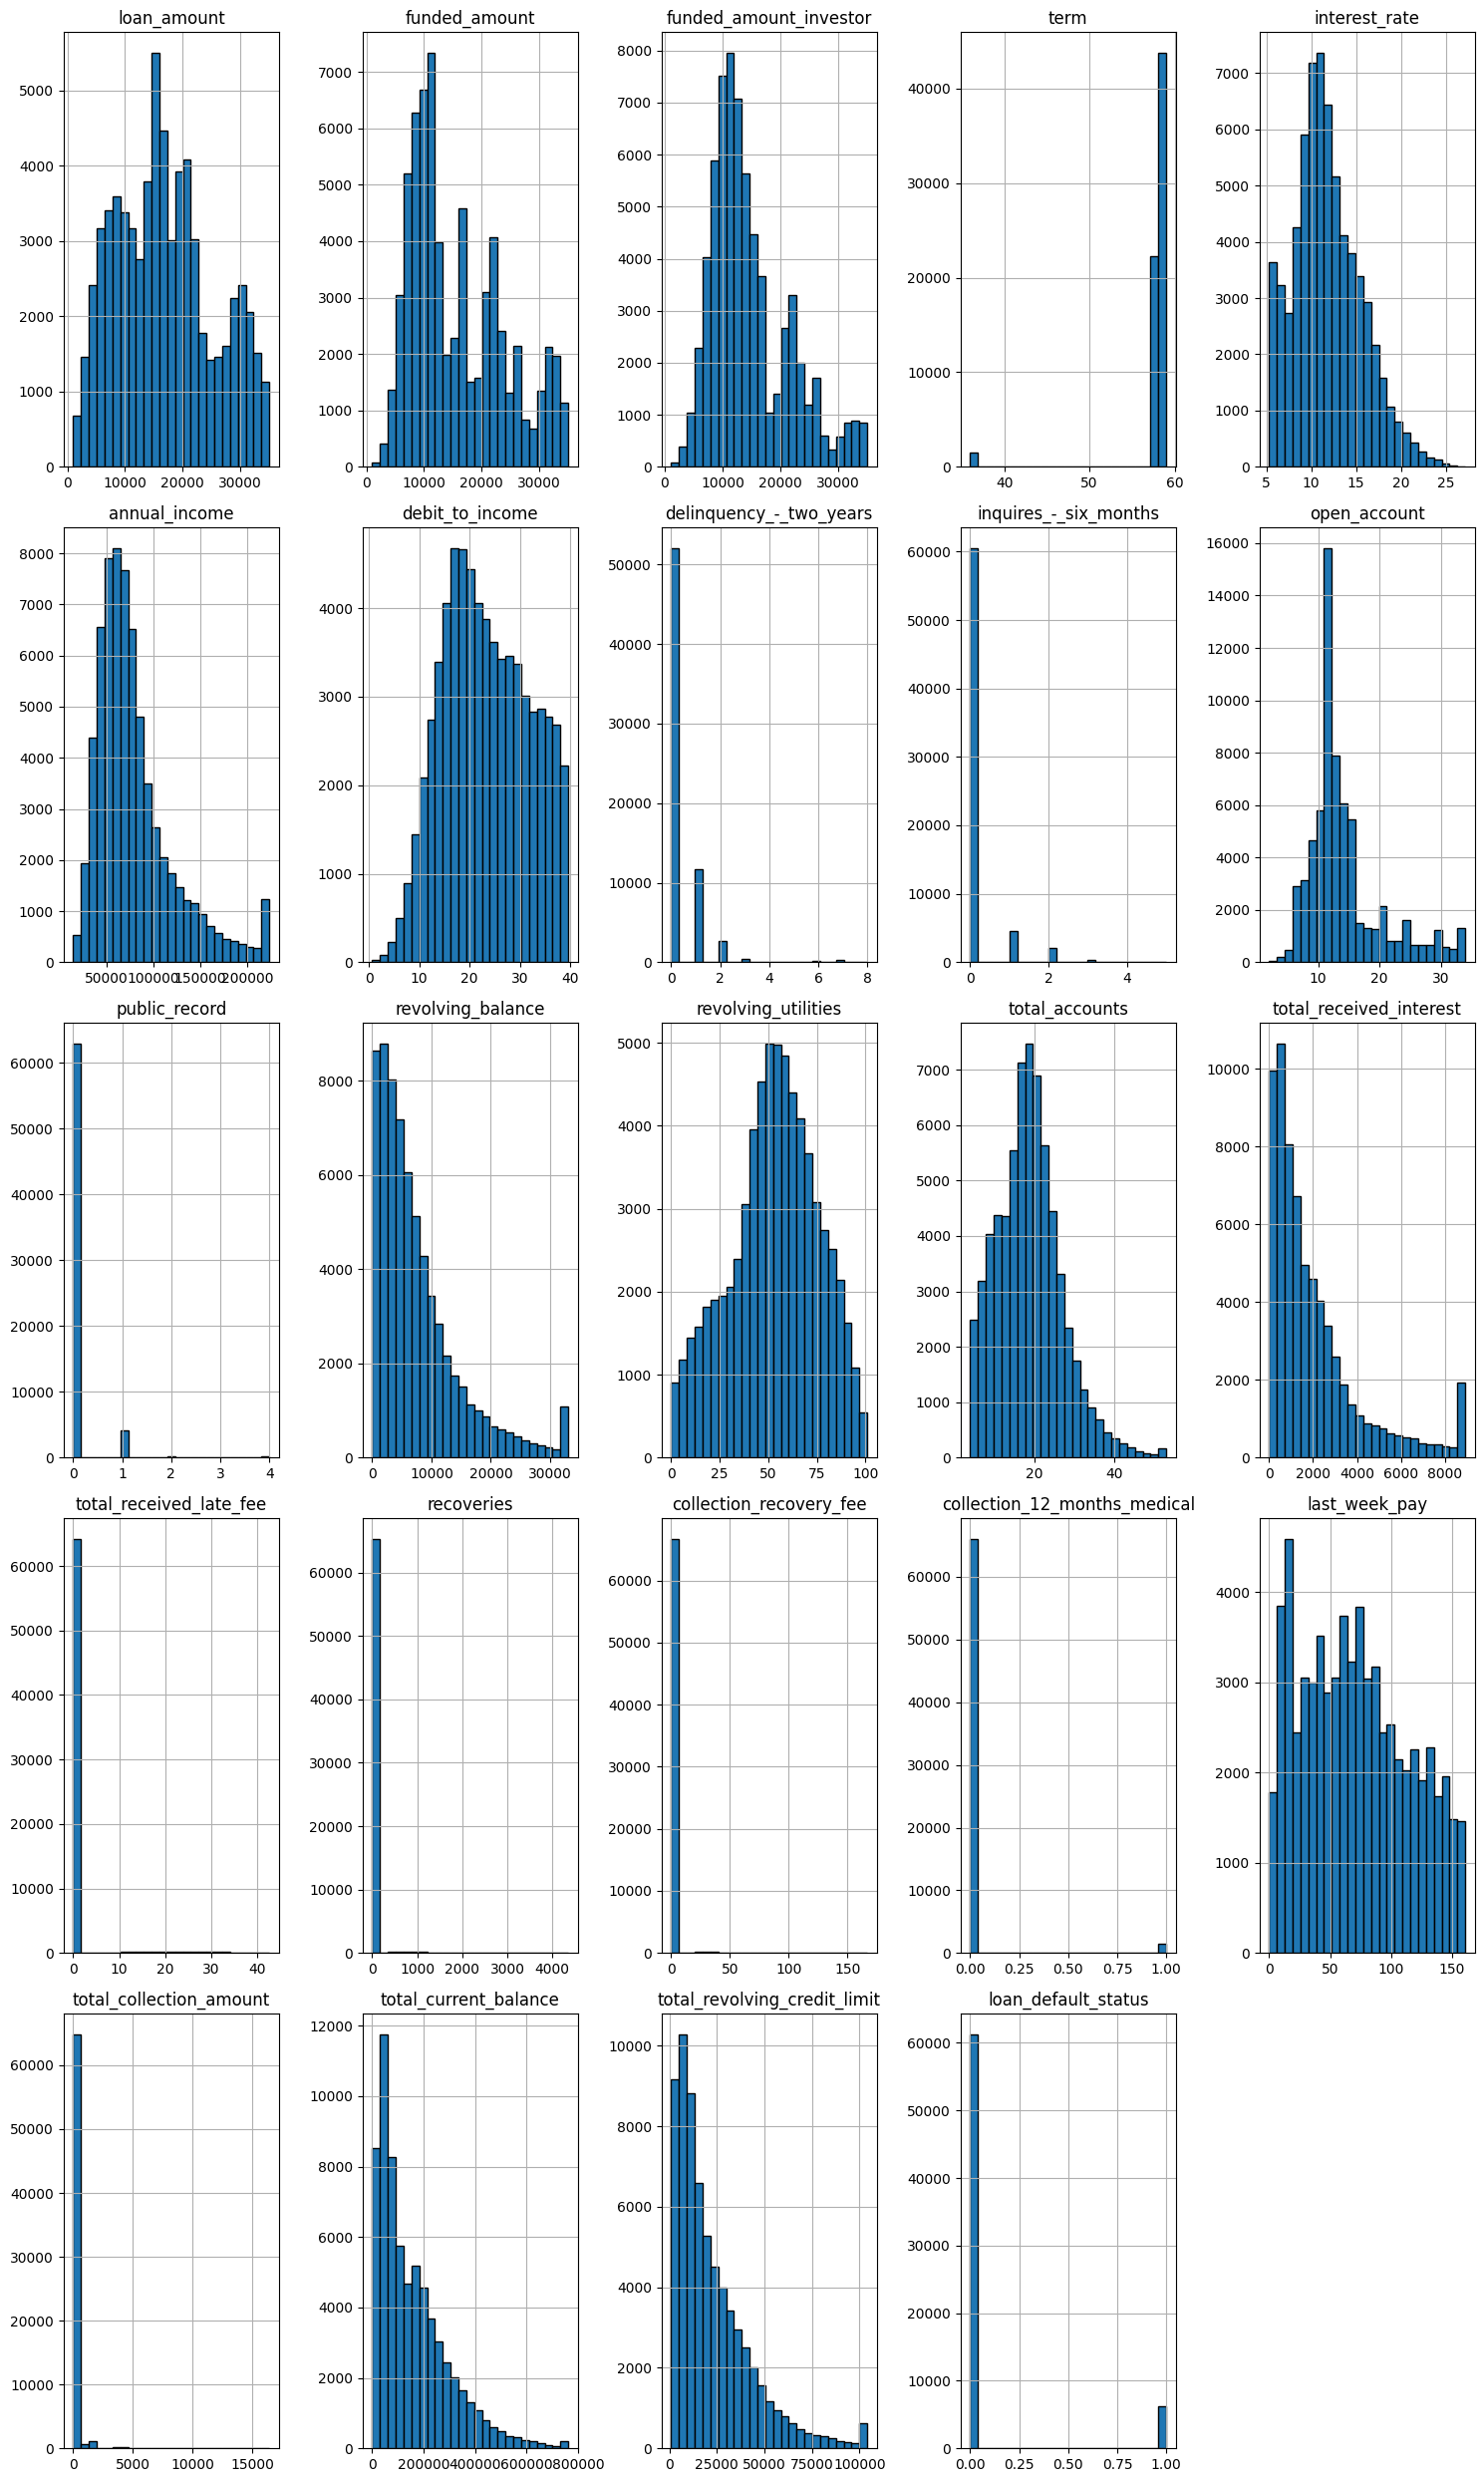

In [ ]:
df.hist(bins=25, figsize=(15, 25), layout=(-1, 5), edgecolor="black")
plt.tight_layout();

In [ ]:
# total_current_balance, total_revolving_credit_limit revolving_balance are highly skewed.  Log transformation is applied
#var=["total_current_balance", "total_revolving_credit_limit", "revolving_balance"]

df["log_total_current_balance"]=np.log(1+df.total_current_balance)
df["log_total_revolving_credit_limit"]=np.log(1+df.total_revolving_credit_limit)
df["log_revolving_balance"]=np.log(1+df.revolving_balance)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67463 entries, 0 to 67462
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   loan_amount                       67463 non-null  int64  
 1   funded_amount                     67463 non-null  int64  
 2   funded_amount_investor            67463 non-null  float64
 3   term                              67463 non-null  int64  
 4   batch_enrolled                    67463 non-null  object 
 5   interest_rate                     67463 non-null  float64
 6   grade                             67463 non-null  object 
 7   sub_grade                         67463 non-null  object 
 8   home_ownership                    67463 non-null  object 
 9   annual_income                     67463 non-null  float64
 10  loan_title                        67463 non-null  object 
 11  debit_to_income                   67463 non-null  float64
 12  deli

In [ ]:
df.select_dtypes(exclude='object').drop(columns='loan_default_status').describe(percentiles=[0.01,0.05,0.10,0.25,0.50,0.75,0.9,0.99]).T

count           mean            std  \
loan_amount                       67463.0   16848.902776    8367.865726   
funded_amount                     67463.0   15770.599114    8150.992662   
funded_amount_investor            67463.0   14621.799323    6785.345170   
term                              67463.0      58.173814       3.327441   
interest_rate                     67463.0      11.846258       3.718629   
annual_income                     67463.0   80541.502522   45029.120366   
debit_to_income                   67463.0      23.299241       8.451824   
delinquency_-_two_years           67463.0       0.327127       0.800888   
inquires_-_six_months             67463.0       0.145754       0.473291   
open_account                      67463.0      14.266561       6.225060   
public_record                     67463.0       0.081437       0.346606   
revolving_balance                 67463.0    7699.342425    7836.148190   
revolving_utilities               67463.0      52.889443      22.539450   
total_accounts                    67463.0      18.627929       8.319246   
total_received_interest           67463.0    2068.992542    2221.918745   
total_received_late_fee           67463.0       1.143969       5.244365   
recoveries                        67463.0      59.691578     357.026346   
collection_recovery_fee           67463.0       1.125141       3.489885   
collection_12_months_medical      67463.0       0.021301       0.144385   
last_week_pay                     67463.0      71.163260      43.315845   
total_collection_amount           67463.0     146.467990     744.382233   
total_current_balance             67463.0  159573.933638  139033.245565   
total_revolving_credit_limit      67463.0   23123.005544   20916.699999   
log_total_current_balance         67463.0      11.554839       1.019281   
log_total_revolving_credit_limit  67463.0       9.646608       0.959859   
log_revolving_balance             67463.0       8.438032       1.181043   

                                           min            1%            5%  \
loan_amount                        1014.000000   2358.240000   4485.100000   
funded_amount                      1014.000000   4017.620000   5894.300000   
funded_amount_investor             1114.590204   4224.114235   6327.979784   
term                                 36.000000     36.000000     58.000000   
interest_rate                         5.320006      5.493987      6.134823   
annual_income                     14573.537170  24036.927676  33448.726146   
debit_to_income                       0.675299      6.461818     10.205682   
delinquency_-_two_years               0.000000      0.000000      0.000000   
inquires_-_six_months                 0.000000      0.000000      0.000000   
open_account                          2.000000      5.000000      7.000000   
public_record                         0.000000      0.000000      0.000000   
revolving_balance                     0.000000    107.000000    528.000000   
revolving_utilities                   0.005172      3.157961     11.714745   
total_accounts                        4.000000      4.000000      6.000000   
total_received_interest               4.736746     46.428515    160.096224   
total_received_late_fee               0.000003      0.000841      0.004222   
recoveries                            0.000036      0.064410      0.331312   
collection_recovery_fee               0.000036      0.028869      0.130243   
collection_12_months_medical          0.000000      0.000000      0.000000   
last_week_pay                         0.000000      3.000000      9.000000   
total_collection_amount               1.000000      3.000000      9.000000   
total_current_balance               617.000000   6955.160000  18215.300000   
total_revolving_credit_limit       1000.000000   1380.620000   2723.200000   
log_total_current_balance             6.426488      8.847382      9.810072   
log_total_revolving_credit_limit      6.908755      7.231012

In [ ]:
#"collection_recovery_fee"  "total_received_late_fee"  "recoveries", "total_collection_amount"
# these features indicate high possibilities of defaults and data is nosiy; transform to dummuy variables using 90p as cutoffs becasue overall bad rate is around 10%

df["collection_recovery_fee_ind"]=0
df.loc[df["collection_recovery_fee"]>1.3, "collection_recovery_fee_ind"]=1

df["total_received_late_fee_ind"]=0

df.loc[df["total_received_late_fee"]>7.56,"total_received_late_fee_ind"]=1

df["recoveries_ind"]=0

df.loc[df["recoveries"]>7.5,"recoveries_ind"]=1

In [ ]:
drop_list=["batch_enrolled", "collection_recovery_fee","recoveries","total_received_late_fee","total_current_balance","total_revolving_credit_limit","revolving_balance"]

df_mr=df.drop(columns=drop_list,axis=1)
df_mr.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 67463 entries, 0 to 67462
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   loan_amount                       67463 non-null  int64  
 1   funded_amount                     67463 non-null  int64  
 2   funded_amount_investor            67463 non-null  float64
 3   term                              67463 non-null  int64  
 4   interest_rate                     67463 non-null  float64
 5   grade                             67463 non-null  object 
 6   sub_grade                         67463 non-null  object 
 7   home_ownership                    67463 non-null  object 
 8   annual_income                     67463 non-null  float64
 9   loan_title                        67463 non-null  object 
 10  debit_to_income                   67463 non-null  float64
 11  delinquency_-_two_years           67463 non-null  int64  
 12  inqu

In [ ]:
df_mr.select_dtypes(exclude='object').drop(columns='loan_default_status').describe(percentiles=[0.01,0.05,0.10,0.25,0.50,0.75,0.9,0.99]).T

count          mean           std  \
loan_amount                       67463.0  16848.902776   8367.865726   
funded_amount                     67463.0  15770.599114   8150.992662   
funded_amount_investor            67463.0  14621.799323   6785.345170   
term                              67463.0     58.173814      3.327441   
interest_rate                     67463.0     11.846258      3.718629   
annual_income                     67463.0  80541.502522  45029.120366   
debit_to_income                   67463.0     23.299241      8.451824   
delinquency_-_two_years           67463.0      0.327127      0.800888   
inquires_-_six_months             67463.0      0.145754      0.473291   
open_account                      67463.0     14.266561      6.225060   
public_record                     67463.0      0.081437      0.346606   
revolving_utilities               67463.0     52.889443     22.539450   
total_accounts                    67463.0     18.627929      8.319246   
total_received_interest           67463.0   2068.992542   2221.918745   
collection_12_months_medical      67463.0      0.021301      0.144385   
last_week_pay                     67463.0     71.163260     43.315845   
total_collection_amount           67463.0    146.467990    744.382233   
log_total_current_balance         67463.0     11.554839      1.019281   
log_total_revolving_credit_limit  67463.0      9.646608      0.959859   
log_revolving_balance             67463.0      8.438032      1.181043   
collection_recovery_fee_ind       67463.0      0.099477      0.299303   
total_received_late_fee_ind       67463.0      0.046129      0.209766   
recoveries_ind                    67463.0      0.103405      0.304489   

                                           min            1%            5%  \
loan_amount                        1014.000000   2358.240000   4485.100000   
funded_amount                      1014.000000   4017.620000   5894.300000   
funded_amount_investor             1114.590204   4224.114235   6327.979784   
term                                 36.000000     36.000000     58.000000   
interest_rate                         5.320006      5.493987      6.134823   
annual_income                     14573.537170  24036.927676  33448.726146   
debit_to_income                       0.675299      6.461818     10.205682   
delinquency_-_two_years               0.000000      0.000000      0.000000   
inquires_-_six_months                 0.000000      0.000000      0.000000   
open_account                          2.000000      5.000000      7.000000   
public_record                         0.000000      0.000000      0.000000   
revolving_utilities                   0.005172      3.157961     11.714745   
total_accounts                        4.000000      4.000000      6.000000   
total_received_interest               4.736746     46.428515    160.096224   
collection_12_months_medical          0.000000      0.000000      0.000000   
last_week_pay                         0.000000      3.000000      9.000000   
total_collection_amount               1.000000      3.000000      9.000000   
log_total_current_balance             6.426488      8.847382      9.810072   
log_total_revolving_credit_limit      6.908755      7.231012      7.909930   
log_revolving_balance                 0.000000      4.682131      6.270988   
collection_recovery_fee_ind           0.000000      0.000000      0.000000   
total_received_late_fee_ind           0.000000      0.000000      0.000000   
recoveries_ind                        0.000000      0.000000      0.000000   

                                           10%           25%           50%  \
loan_amount                        6053.000000  10012.000000  16073.000000   
funded_amount                      6986.000000   9266.500000  13042.000000   
funded_amount_investor             7591.177420   9831.684984  12793.682170   
term                                 58.000000     58.000000     59.000000   
interest_rate       

In [ ]:
# Select object type data and numerical data columns seperately

cate = [i for i in df_mr.select_dtypes(include='object').columns]
num = [i for i in df_mr.select_dtypes(exclude='object').columns]
print(cate)
print(num)

['grade', 'sub_grade', 'home_ownership', 'loan_title']
['loan_amount', 'funded_amount', 'funded_amount_investor', 'term', 'interest_rate', 'annual_income', 'debit_to_income', 'delinquency_-_two_years', 'inquires_-_six_months', 'open_account', 'public_record', 'revolving_utilities', 'total_accounts', 'total_received_interest', 'collection_12_months_medical', 'last_week_pay', 'total_collection_amount', 'loan_default_status', 'log_total_current_balance', 'log_total_revolving_credit_limit', 'log_revolving_balance', 'collection_recovery_fee_ind', 'total_received_late_fee_ind', 'recoveries_ind']


In [ ]:
#One-Hot Encoding of Categorical Column
#cat=['grade', 'sub_grade', 'home_ownership',"loan_title", "verification_status", "initial_list_status","application_type","term"]
cat=['grade', 'sub_grade', 'home_ownership', 'loan_title']


df_mr= pd.get_dummies(df_mr, columns = cat,drop_first=True)

df_mr.head()

loan_amount  funded_amount  funded_amount_investor  term  interest_rate  \
0        10000          32236             12329.36286    59      11.135007   
1         3609          11940             12191.99692    59      12.237563   
2        28276           9311             21603.22455    59      12.545884   
3        11170           6954             17877.15585    59      16.731201   
4        16890          13226             13539.92667    59      15.008300   

   annual_income  debit_to_income  delinquency_-_two_years  \
0   176346.62670        16.284758                        1   
1    39833.92100        15.412409                        0   
2    91506.69105        28.137619                        0   
3   108286.57590        18.043730                        1   
4    44234.82545        17.209886                        1   

   inquires_-_six_months  open_account  public_record  revolving_utilities  \
0                      0            13              0            74.932551   
1                      0            12              0            78.297186   
2                      0            14              0             2.073040   
3                      0             7              0            67.467951   
4                      3            13              1            85.250761   

   total_accounts  total_received_interest  collection_12_months_medical  \
0               7              2929.646315                             0   
1              13               772.769385                             0   
2              20               863.324396                             0   
3              12               288.173196                             0   
4              22               129.239553                             0   

   last_week_pay  total_collection_amount  loan_default_status  \
0             49                       31                    0   
1            109                       53                    0   
2             66                       34                    0   
3             39                       40                    0   
4             18                      430                    0   

   log_total_current_balance  log_total_revolving_credit_limit  \
0                  12.648519                          8.797851   
1                  12.115113                          9.946834   
2                  11.405363                         10.171834   
3                   9.125871                         11.005677   
4                  11.744275                         10.024820   

   log_revolving_balance  collection_recovery_fee_ind  \
0              10.096048                            0   
1               6.700731                            0   
2               7.519692                            0   
3               9.533872                            0   
4               7.342779                            0   

   total_received_late_fee_ind  recoveries_ind  grade_b  grade_c  grade_d  \
0                            0               0        1        0        0   
1                            0               0        0        1        0   
2                            1               0        0        0        0   
3                            0               0        0        1        0   
4                            1               1        0        1        0   

   grade_e  grade_f  grade_g  sub_grade_a2  sub_grade_a3  sub_grade_a4  \
0        0        0        0             0             0             0   
1        0        0        0             0             0             0   
2        0        1        0             0             0             0   
3        0        0        0             0             0             0   
4        0        0        0             0             0             0   

   sub_grade_a5  sub_grade_b1  sub_grade_b2  sub_grade_b3  sub_grade_b4  \
0             0             0             0             0             0   
1             0             0           

In [ ]:
# split into train and test sets
#TargetEncode

X_train_enc = prepare_inputs(df_mr, df_mr)
#y_train_enc, y_test_enc = prepare_targets(df.loan_default_status, df.loan_default_status)
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X_train_enc, columns=df_mr.drop(columns='loan_default_status', axis=1).columns.tolist())
, df.loan_default_status, test_size=0.20, random_state=10)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head(1)


(53970, 147)
(53970,)
(13493, 147)
(13493,)


loan_amount  funded_amount  funded_amount_investor      term  \
3766     0.256234       0.256234                0.092513  0.097314   

      interest_rate  annual_income  debit_to_income  delinquency_-_two_years  \
3766       0.092513       0.092513         0.092513                 0.091488   

      inquires_-_six_months  open_account  public_record  revolving_utilities  \
3766                0.09234      0.095268        0.09213             0.092513   

      total_accounts  total_received_interest  collection_12_months_medical  \
3766        0.109409                 0.092513                      0.092601   

      last_week_pay  total_collection_amount  log_total_current_balance  \
3766       0.096766                 0.092504                   0.092513   

      log_total_revolving_credit_limit  log_revolving_balance  \
3766                               0.0                    0.0   

      collection_recovery_fee_ind  total_received_late_fee_ind  \
3766                     0.093866                     0.091988   

      recoveries_ind   grade_b   grade_c   grade_d   grade_e  grade_f  \
3766         0.09218  0.088971  0.092085  0.092144  0.092242  0.09215   

       grade_g  sub_grade_a2  sub_grade_a3  sub_grade_a4  sub_grade_a5  \
3766  0.092419      0.092301      0.092566      0.092472      0.092525   

      sub_grade_b1  sub_grade_b2  sub_grade_b3  sub_grade_b4  sub_grade_b5  \
3766      0.092295      0.092672      0.093054      0.091472       0.09247   

      sub_grade_c1  sub_grade_c2  sub_grade_c3  sub_grade_c4  sub_grade_c5  \
3766      0.093451      0.092421      0.092509      0.092374      0.092609   

      sub_grade_d1  sub_grade_d2  sub_grade_d3  sub_grade_d4  sub_grade_d5  \
3766      0.092379      0.092224      0.092549      0.092664      0.092069   

      sub_grade_e1  sub_grade_e2  sub_grade_e3  sub_grade_e4  sub_grade_e5  \
3766      0.092345      0.092661      0.092449      0.092266      0.092585   

      sub_grade_f1  sub_grade_f2  sub_grade_f3  sub_grade_f4  sub_grade_f5  \
3766      0.092619      0.092437      0.092514      0.092433       0.09252   

      sub_grade_g1  sub_grade_g2  sub_grade_g3  sub_grade_g4  sub_grade_g5  \
3766      0.092499      0.092599      0.092331      0.092515      0.092438   

      home_ownership_own  home_ownership_rent  loan_title_bill_consolidation  \
3766            0.091536             0.091153                       0.092515   

      loan_title_bill_payoff  loan_title_bills  loan_title_business  \
3766                0.092511          0.092482             0.092596   

      loan_title_car_financing  loan_title_car_loan  \
3766                  0.092457             0.092523   

      loan_title_card_consolidation  loan_title_cards  loan_title_cc  \
3766                       0.092515          0.092481       0.092521   

      loan_title_cc-refinance  loan_title_cc_consolidation  \
3766                 0.092533                     0.092505   

      loan_title_cc_loan  loan_title_cc_refi  loan_title_cc_refinance  \
3766            0.092526            0.092476                 0.092516   

      loan_title_conso  loan_title_consolidate  loan_title_consolidated  \
3766          0.092504                0.092568                  0.09253   

      loan_title_consolidation  loan_title_consolidation_loan  \
3766                  0.092513                       0.092478   

      loan_title_credit  loan_title_credit_card  \
3766            0.09252                0.092499   

      loan_title_credit_card_consolidation  loan_title_credit_card_debt  \
3766                              0.092452                     0.092534   

      loan_title_credit_card_loan  loan_title_credit_card_pay_off  \
3766                     0.092426                        0.092493   

      loan_title_credit_card_paydown  loan_title_credit_card_payoff  \
3766                        0.092528                       0.092475   

      loan_title_credit_card_refi  loan_title_credit_card_refinance  \
3766    

In [ ]:
#Accuracy Score
model =  LogisticRegression(solver='liblinear', random_state=12)
model.fit(X_train, y_train)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.4f' % (accuracy*100))

LogisticRegression(random_state=12, solver='liblinear')

Accuracy: 90.8471


##Feature Coeffiecients

['loan_amount', 'funded_amount', 'funded_amount_investor', 'term', 'batch_enrolled', 'interest_rate', 'grade', 'sub_grade', 'home_ownership', 'annual_income', 'loan_title', 'debit_to_income', 'delinquency_-_two_years', 'inquires_-_six_months', 'open_account', 'public_record', 'revolving_balance', 'revolving_utilities', 'total_accounts', 'total_received_interest', 'total_received_late_fee', 'recoveries', 'collection_recovery_fee', 'collection_12_months_medical', 'last_week_pay', 'total_collection_amount', 'total_current_balance', 'total_revolving_credit_limit', 'log_total_current_balance', 'log_total_revolving_credit_limit', 'log_revolving_balance', 'collection_recovery_fee_ind', 'total_received_late_fee_ind', 'recoveries_ind']
Feature: 0, Score: 0.12835
Feature: 1, Score: -0.16642
Feature: 2, Score: -0.39642
Feature: 3, Score: 1.79162
Feature: 4, Score: -0.25919
Feature: 5, Score: -0.21650
Feature: 6, Score: -0.19938
Feature: 7, Score: -0.29906
Feature: 8, Score: -0.24369
Feature: 9, S

<BarContainer object of 147 artists>

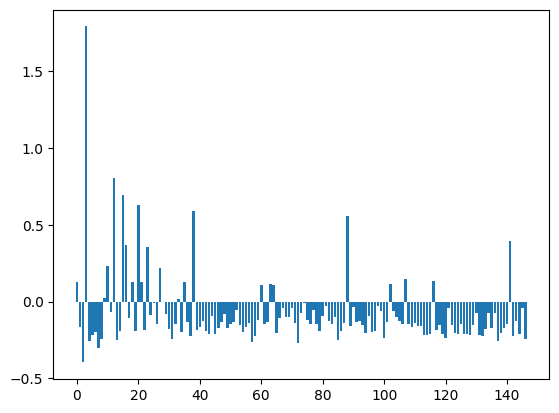

In [ ]:

coeffs = model.coef_.reshape(-1)
# visualizing coefficients
index = pd.DataFrame(X_train, columns = df.drop(columns='loan_default_status', axis=1).columns.tolist()).columns.tolist()
print(index)
#(pd.DataFrame(coeffs, index = index, columns = ['coeff']).sort_values(by = 'coeff')
 #.plot(kind='barh', figsize=(8,24)))
# summarize feature importance
for i,v in enumerate(coeffs):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(coeffs))], coeffs)
plt.show()

In [ ]:
'''
# filter variables near zero coefficient value
temp = pd.DataFrame(coeffs, index = index, columns = ['coeff']).sort_values(by = 'coeff')
temp = temp[(temp['coeff']>1) | (temp['coeff']< -1)]
# drop those features
cols_coeff = temp.index.to_list()
X_train = pd.DataFrame(X_train, columns = df.drop(columns='loan_default_status', axis=1).columns.tolist())[cols_coeff]
X_test = pd.DataFrame(X_test, columns = df.drop(columns='loan_default_status', axis=1).columns.tolist())[cols_coeff]
X_train.head(5)
X_train.shape
'''

"\n# filter variables near zero coefficient value\ntemp = pd.DataFrame(coeffs, index = index, columns = ['coeff']).sort_values(by = 'coeff')\ntemp = temp[(temp['coeff']>1) | (temp['coeff']< -1)]\n# drop those features\ncols_coeff = temp.index.to_list()\nX_train = pd.DataFrame(X_train, columns = df.drop(columns='loan_default_status', axis=1).columns.tolist())[cols_coeff]\nX_test = pd.DataFrame(X_test, columns = df.drop(columns='loan_default_status', axis=1).columns.tolist())[cols_coeff]\nX_train.head(5)\nX_train.shape\n"

In [ ]:
#Recheck Accuracy Score
model = LogisticRegression(solver='liblinear', random_state=12)
model.fit(X_train, y_train)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

LogisticRegression(random_state=12, solver='liblinear')

Accuracy: 90.85


[[12258     0]
 [ 1235     0]]


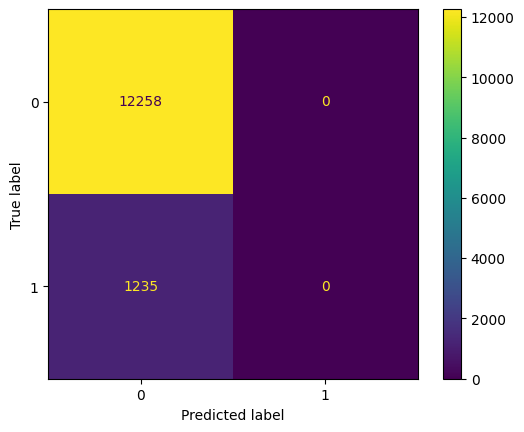

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     12258
           1       0.00      0.00      0.00      1235

    accuracy                           0.91     13493
   macro avg       0.45      0.50      0.48     13493
weighted avg       0.83      0.91      0.86     13493



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, yhat)
print(cm)
# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
print(classification_report(y_test, yhat))

In [ ]:
print('Percentage of Non Defaulters :',(y_train[y_train==0].value_counts()/len(y_train) ) * 100)
print('Percentage of Defaulters :',(y_train[y_train==1].value_counts()/len(y_train) ) * 100)

Percentage of Non Defaulters : 0    90.724477
Name: loan_default_status, dtype: float64
Percentage of Defaulters : 1    9.275523
Name: loan_default_status, dtype: float64


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, yhat)
print(fpr, tpr, thresholds)

[0. 1.] [0. 1.] [inf  0.]


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score=roc_auc_score(y_test, yhat)
roc_auc_score

0.5

In [ ]:
roc_auc = auc(fpr, tpr)
roc_auc

0.5

<Figure size 500x500 with 0 Axes>

(-0.02, 1.02)

(-0.02, 1.02)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC curve')

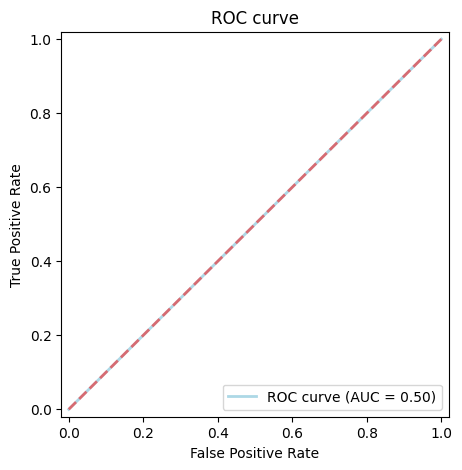

In [ ]:
#plot roc curve

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='lightblue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

##  Neural Network

In [ ]:
# keras - tensorflow
# check version
!pip install keras-tuner --upgrade
import tensorflow as tf
print(tensorflow.__version__)
from tensorflow import keras
# mlp for binary classification
import pandas as pd
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Dropout
%matplotlib inline
import keras_tuner
!pip install smote-variants

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 26.7 MB/s eta 0:00:00
2.13.0
Using TensorFlow backend
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.2/416.2 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.7 MB/s eta 0:00:00
  Created wheel for minisom: filename=MiniSom-2.3.1-py3-none-any.whl size=10588 sha256=43a948820ff580a4c7e5ab04c26b53900b00e0f04fe0de8774102597fa203fe3
  Stored in directory: /root/.cache/pip/wheels/c7/92/d2/33bbda5f86fd8830510b16aa98c8dd420129b5cb24248fd6db
  Created wheel for statistics: filename=statistics-1.0.3.5-py3-none-any.whl size=7436 sha256=97474e94893f9a118a40aac17715cabf1b8e106459ecc058157df478c056c772
  Stored in directory: /root/.cache/pip/wheels/59/bd/aa/41ad56fbb723d36e457b5be74feb992cdac2855a6999ba34a1
Successfully built minisom statist

In [ ]:

X=df_mr.drop(columns=["loan_default_status"],axis=1).values
y=df_mr["loan_default_status"].astype('float32').values
X=X.astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(53970, 147) (13493, 147) (53970,) (13493,)


In [ ]:
'''
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df_mr)
# apply transform
normalized = scaler.transform(df_mr)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
'''

In [ ]:
# Shape before oversampling
print("Before OverSampling count of yes: {}".format(sum(y_train==1)))
print("Before OverSampling count of no: {} \n".format(sum(y_train==0)))

Before OverSampling count of yes: 5041
Before OverSampling count of no: 48929 



In [ ]:
import smote_variants as sv
import numpy as np
# Instantiating the SMOTE class
oversampler= sv.SMOTE()
# Creating new training set
X_train_so, y_train_so = oversampler.sample(np.array(X_train), np.array(y_train))


2023-10-21 02:18:16,250:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'SMOTE'}")
INFO:smote_variants:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'SMOTE'}")
2023-10-21 02:18:16,267:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-10-21 02:18:16,277:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-10-21 02:18:17,156:INFO:SMOTE: simplex sampl

In [ ]:
# Shape after oversampling
print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))
print("After OverSampling, counts of label 'Yes': {}".format(sum(y_train_so==1)))
print("After OverSampling, counts of label 'no': {}".format(sum(y_train_so==0)))

After OverSampling, the shape of train_X: (53970, 147)
After OverSampling, the shape of train_y: (53970,) 

After OverSampling, counts of label 'Yes': 48929
After OverSampling, counts of label 'no': 48929


In [ ]:

X_train.shape
n_features = X_train.shape[1]
print("num of features:" + str(n_features))


(53970, 147)

num of features:147


In [ ]:
'''
#hyperparameter Tunning
def nn_builder(hp) :
  model = keras.Sequential()
 # Tune the number of layers.
  for i in range(hp.Int("num_layers", 2,5)):
    model.add(keras.layers.Dense(
        hp.Choice('units', [16,32,48,60,72]),
        activation='relu', input_shape=(n_features,)))
    model.add(keras.layers.Dense(hp.Choice('units', [16,32,48,60,72]), activation='relu'))
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt , loss='binary_crossentropy')
  return model
tuner = keras_tuner.RandomSearch(
    hypermodel=nn_builder,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,

)
'''

In [ ]:
'''
tuner.search(X_train, y_train, epochs=1, validation_data=(X_test, y_test))
tuner.search_space_summary()
'''

In [ ]:
'''
# Get the top 2 models.
models = tuner.get_best_models(num_models=1)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 28, 28))
best_model.summary()
'''

In [ ]:


metrics = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
#add dropout for Regularization
import keras.backend as K


'''
def weighted_binary_crossentropy(y_true, y_pred):

    weight_positive = 1.0
    weight_negative = 10.0

    # Compute binary cross-entropy loss with weights
    loss = - (weight_positive * y_true * tf.math.log(y_pred + 1e-10) +
              weight_negative * (1.0 - y_true) * tf.math.log(1.0 - y_pred + 1e-10))

    return tf.reduce_mean(loss)
'''

model = Sequential()
model.add(Dense(60, activation='relu', kernel_initializer='truncated_normal', input_shape=(n_features,)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_initializer='truncated_normal'))



model.add(Dense(1, activation='sigmoid'))
# compile the model
opt = keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=metrics)

#model.compile(optimizer=opt, loss=weighted_binary_crossentropy, metrics=metrics)

# train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)


'\ndef weighted_binary_crossentropy(y_true, y_pred):\n\n    weight_positive = 1.0\n    weight_negative = 10.0\n\n    # Compute binary cross-entropy loss with weights\n    loss = - (weight_positive * y_true * tf.math.log(y_pred + 1e-10) +\n              weight_negative * (1.0 - y_true) * tf.math.log(1.0 - y_pred + 1e-10))\n\n    return tf.reduce_mean(loss)\n'

Epoch 1/20
1687/1687 [==============================] - 17s 8ms/step - loss: 493835584.0000 - cross entropy: 493835584.0000 - Brier score: 0.1053 - tp: 19.0000 - fp: 118.0000 - tn: 48811.0000 - fn: 5022.0000 - accuracy: 0.9048 - precision: 0.1387 - recall: 0.0038 - auc: 0.4975 - prc: 0.0930
Epoch 2/20
1687/1687 [==============================] - 10s 6ms/step - loss: 0.6938 - cross entropy: 0.6938 - Brier score: 0.0847 - tp: 0.0000e+00 - fp: 1.0000 - tn: 48928.0000 - fn: 5041.0000 - accuracy: 0.9066 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4965 - prc: 0.0914
Epoch 3/20
1687/1687 [==============================] - 8s 5ms/step - loss: 65441.9766 - cross entropy: 65441.9766 - Brier score: 0.0856 - tp: 1.0000 - fp: 20.0000 - tn: 48909.0000 - fn: 5040.0000 - accuracy: 0.9062 - precision: 0.0476 - recall: 1.9837e-04 - auc: 0.4892 - prc: 0.0913
Epoch 4/20
1687/1687 [==============================] - 10s 6ms/step - loss: 0.3105 - cross entropy: 0.3105 - Brier score: 0.0847 - tp: 0.

422/422 [==============================] - 1s 2ms/step
[[12293     0]
 [ 1200     0]]


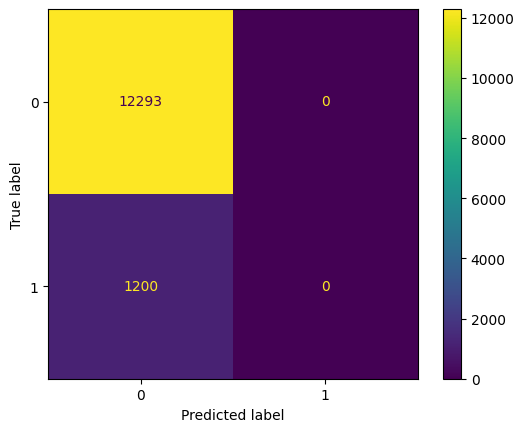

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     12293
         1.0       0.00      0.00      0.00      1200

    accuracy                           0.91     13493
   macro avg       0.46      0.50      0.48     13493
weighted avg       0.83      0.91      0.87     13493



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
yhat = model.predict(X_test)
# Compute confusion matrix
cm = confusion_matrix(y_test, yhat>0.5)
print(cm)
# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
print(classification_report(y_test, yhat>0.5))

In [ ]:
# evaluate the model for train dataset
Results =model.evaluate(X_train, y_train, verbose=0)
print("accuary and ROC:")
print(Results[7], Results[10])

In [ ]:
# evaluate the model
Results =model.evaluate(X_test, y_test, verbose=0)
print("accuary and ROC:")
print(Results[7], Results[10])


accuary and ROC:
0.9110649824142456 0.5


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, yhat)
print(fpr, tpr, thresholds)

[0. 1.] [0. 1.] [      inf 0.0957134]


<Figure size 500x500 with 0 Axes>

(-0.02, 1.02)

(-0.02, 1.02)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC curve')

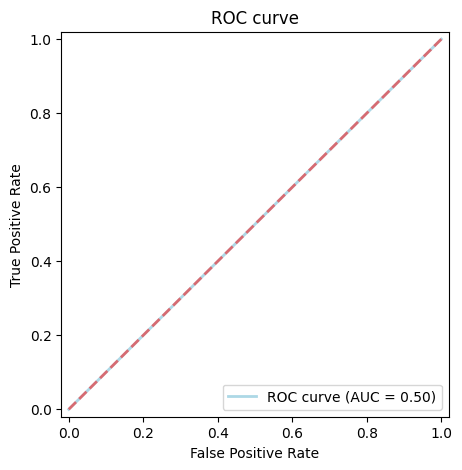

In [ ]:
#plot roc curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='lightblue', lw=2, label='ROC curve (AUC = %0.2f)' % Results[10])
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#SMOTE

metrics = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
#add dropout for Regularization
import keras.backend as K


'''
def weighted_binary_crossentropy(y_true, y_pred):

    weight_positive = 1.0
    weight_negative = 10.0

    # Compute binary cross-entropy loss with weights
    loss = - (weight_positive * y_true * tf.math.log(y_pred + 1e-10) +
              weight_negative * (1.0 - y_true) * tf.math.log(1.0 - y_pred + 1e-10))

    return tf.reduce_mean(loss)
'''

model = Sequential()
model.add(Dense(60, activation='relu', kernel_initializer='truncated_normal', input_shape=(n_features,)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_initializer='truncated_normal'))

model.add(Dense(1, activation='sigmoid'))
# compile the model
opt = keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=metrics)

#model.compile(optimizer=opt, loss=weighted_binary_crossentropy, metrics=metrics)

# train the model
model.fit(X_train_so, y_train_so, epochs=20, batch_size=32, verbose=1)
#yhat = model.predict(X_test)

'\ndef weighted_binary_crossentropy(y_true, y_pred):\n\n    weight_positive = 1.0\n    weight_negative = 10.0\n\n    # Compute binary cross-entropy loss with weights\n    loss = - (weight_positive * y_true * tf.math.log(y_pred + 1e-10) +\n              weight_negative * (1.0 - y_true) * tf.math.log(1.0 - y_pred + 1e-10))\n\n    return tf.reduce_mean(loss)\n'

Epoch 1/20
3059/3059 [==============================] - 24s 7ms/step - loss: 39406.8398 - cross entropy: 39406.8398 - Brier score: 0.2505 - tp: 24079.0000 - fp: 23991.0000 - tn: 24938.0000 - fn: 24850.0000 - accuracy: 0.5009 - precision: 0.5009 - recall: 0.4921 - auc: 0.5013 - prc: 0.5005
Epoch 2/20
3059/3059 [==============================] - 17s 5ms/step - loss: 0.6932 - cross entropy: 0.6932 - Brier score: 0.2500 - tp: 27451.0000 - fp: 27461.0000 - tn: 21468.0000 - fn: 21478.0000 - accuracy: 0.4999 - precision: 0.4999 - recall: 0.5610 - auc: 0.4998 - prc: 0.4994
Epoch 3/20
3059/3059 [==============================] - 17s 6ms/step - loss: 0.6932 - cross entropy: 0.6932 - Brier score: 0.2500 - tp: 25782.0000 - fp: 25802.0000 - tn: 23127.0000 - fn: 23147.0000 - accuracy: 0.4998 - precision: 0.4998 - recall: 0.5269 - auc: 0.4990 - prc: 0.4995
Epoch 4/20
3059/3059 [==============================] - 17s 6ms/step - loss: 0.6932 - cross entropy: 0.6932 - Brier score: 0.2500 - tp: 20125.0000

422/422 [==============================] - 1s 2ms/step
[[    0 12293]
 [    0  1200]]


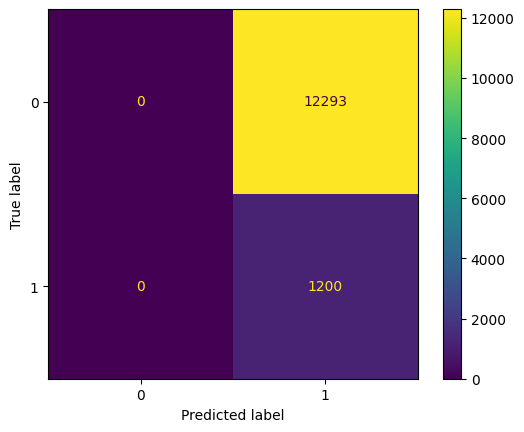

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     12293
         1.0       0.09      1.00      0.16      1200

    accuracy                           0.09     13493
   macro avg       0.04      0.50      0.08     13493
weighted avg       0.01      0.09      0.01     13493



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
yhat = model.predict(X_test)
# Compute confusion matrix
cm = confusion_matrix(y_test, yhat>0.5)
print(cm)
# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
print(classification_report(y_test, yhat>0.5))

In [ ]:
# evaluate the model for train dataset
Results =model.evaluate(X_train_so, y_train_so, verbose=0)
print("accuary and ROC:")
print(Results[7], Results[10])
print(Results)

accuary and ROC:
0.5 0.5
[0.6931403279304504, 0.6931403279304504, 0.25000226497650146, 48929.0, 48929.0, 0.0, 0.0, 0.5, 0.5, 1.0, 0.5, 0.5]


In [ ]:
# evaluate the model
Results =model.evaluate(X_test, y_test, verbose=0)
print("accuary and ROC:")
print(Results[7], Results[10])

accuary and ROC:
0.0889350026845932 0.5


# Other Models

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from time import time
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB, MultinomialNB
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [ ]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
#models.append(('Ridge', RidgeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('AdaBoost', AdaBoostClassifier()))
models.append(('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')))
#models.append(('KNN', KNeighborsClassifier()))


LogisticRegression(solver='liblinear')

Accuracy for training data: %0.3fs 90.65962571799147
ROC for training data: %0.3fs 0.5
Accuracy for testing data:%0.3fs 91.10649966649373
ROC for testing data: %0.3fs 0.5
LR: 0.499789 (0.012362)
Score for each of the 5 K-fold tests: [0.51657985 0.49495452 0.50447558 0.50368095 0.47925323]
LogisticRegression(solver='liblinear')
	Training time: 0.601s
	Prediction time: 3.684s



RandomForestClassifier()

Accuracy for training data: %0.3fs 100.0
ROC for training data: %0.3fs 1.0
Accuracy for testing data:%0.3fs 91.10649966649373
ROC for testing data: %0.3fs 0.5
RF: 0.512145 (0.009545)
Score for each of the 5 K-fold tests: [0.5274918  0.51824068 0.50845884 0.5008575  0.50567742]
RandomForestClassifier()
	Training time: 30.207s
	Prediction time: 141.444s



GradientBoostingClassifier()

Accuracy for training data: %0.3fs 90.68371317398555
ROC for training data: %0.3fs 0.5012894267010514
Accuracy for testing data:%0.3fs 91.0990884162158
ROC for testing data: %0.3fs 0.4999593264459449
GB: 0.528925 (0.009115)
Score for each of the 5 K-fold tests: [0.52269128 0.5401481  0.52725288 0.51626061 0.53827257]
GradientBoostingClassifier()
	Training time: 48.829s
	Prediction time: 237.602s



AdaBoostClassifier()

Accuracy for training data: %0.3fs 90.6614785992218
ROC for training data: %0.3fs 0.5000991866693116
Accuracy for testing data:%0.3fs 91.10649966649373
ROC for testing data: %0.3fs 0.5
AdaBoost: 0.526782 (0.008248)
Score for each of the 5 K-fold tests: [0.52113887 0.5342516  0.52469575 0.51577298 0.53805106]
AdaBoostClassifier()
	Training time: 10.611s
	Prediction time: 50.660s



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Accuracy for training data: %0.3fs 91.79544191217343
ROC for training data: %0.3fs 0.5608903960687561
Accuracy for testing data:%0.3fs 91.01015341288075
ROC for testing data: %0.3fs 0.49984723690989447
XGBoost: 0.498884 (0.009147)
Score for each of the 5 K-fold tests: [0.51550736 0.49111507 0.49404008 0.49187073 0.50188827]
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_est

Text(0.5, 0.98, 'Algorithm Comparison')

{'whiskers': [<matplotlib.lines.Line2D at 0x7bee742142e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7bee74214700>,
 'boxes': [<matplotlib.lines.Line2D at 0x7bee74214040>,
 'medians': [<matplotlib.lines.Line2D at 0x7bee74214c40>,
 'fliers': [<matplotlib.lines.Line2D at 0x7bee74214ee0>,
 'means': []}

[Text(1, 0, 'LR'),
 Text(2, 0, 'RF'),
 Text(3, 0, 'GB'),
 Text(4, 0, 'AdaBoost'),
 Text(5, 0, 'XGBoost')]

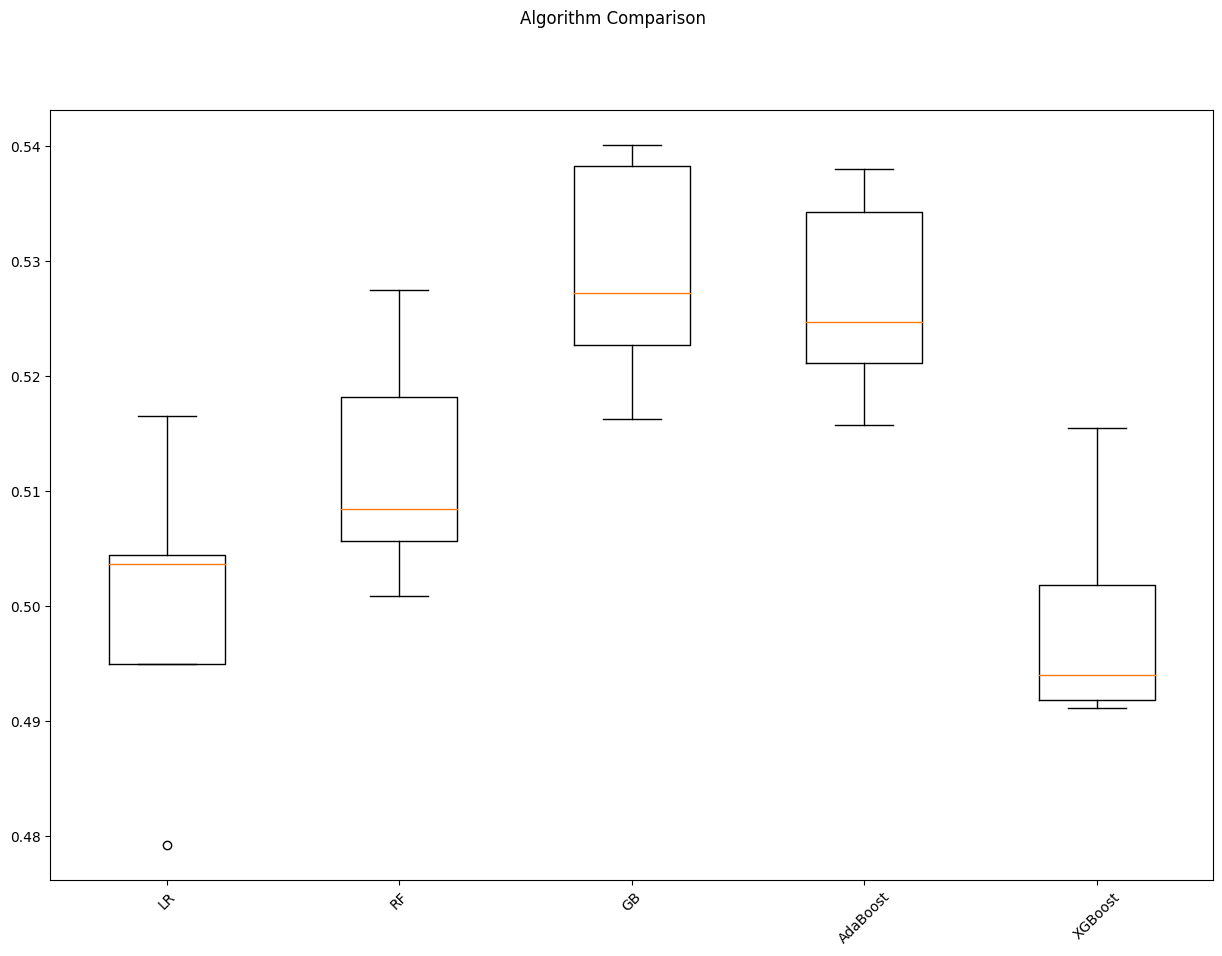

In [ ]:
# Algorithm Harness
# Scoring metrics:
# 'accuracy', 'balanced_accuracy', 'average_precision', 'neg_brier_score', 'f1', 'f1_micro', 'f1_macro', 'f1_weighted',
# 'neg_log_loss', 'precision', 'recall', 'jaccard', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted'
results = []
names = []

scoring = 'roc_auc'
for name, model in models:
    start = time()
    kfold = KFold(n_splits=5, random_state=7, shuffle=True)
    model.fit(X_train, y_train)
    train_time = time() - start
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    predict_time = time() - start
    yhat = model.predict(X_test)
    yhat_train = model.predict(X_train)

       # evaluate predictions on training data
    accuracy_train = accuracy_score(y_train, yhat_train)
    roc_train=roc_auc_score(y_train, yhat_train)
    print("Accuracy for training data: %0.3fs", (accuracy_train*100))
    print("ROC for training data: %0.3fs", (roc_train))

   # evaluate predictions on Testing data
    accuracy_test = accuracy_score(y_test, yhat)
    roc_test=roc_auc_score(y_test, yhat)
    print("Accuracy for testing data:%0.3fs",  (accuracy_test*100))
    print("ROC for testing data: %0.3fs" ,(roc_test))

    #accuracy_test.append(accuracy_test)
    #roc_test.append(roc_test)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    print("Score for each of the 5 K-fold tests:",cv_results)
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print()

fig = pyplot.figure(figsize=(15, 10))  # Change the numbers as needed
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names, rotation = 45)  # Added rotation for better visibility
pyplot.show()

LogisticRegression(solver='liblinear')

Accuracy for training data: %0.3fs 90.65962571799147
ROC for training data: %0.3fs 0.5
Accuracy for testing data:%0.3fs 91.10649966649373
ROC for testing data: %0.3fs 0.5
LR: 0.906596 (0.003642)
Score for each of the 5 K-fold tests: [0.90253845 0.90226052 0.90744858 0.91133963 0.90939411]
LogisticRegression(solver='liblinear')
	Training time: 0.938s
	Prediction time: 6.133s



RandomForestClassifier()

Accuracy for training data: %0.3fs 99.99629423753937
ROC for training data: %0.3fs 0.9998016266613767
Accuracy for testing data:%0.3fs 91.10649966649373
ROC for testing data: %0.3fs 0.5
RF: 0.906596 (0.003642)
Score for each of the 5 K-fold tests: [0.90253845 0.90226052 0.90744858 0.91133963 0.90939411]
RandomForestClassifier()
	Training time: 30.822s
	Prediction time: 141.168s



GradientBoostingClassifier()

Accuracy for training data: %0.3fs 90.68186029275523
ROC for training data: %0.3fs 0.5011902400317397
Accuracy for testing data:%0.3fs 91.10649966649373
ROC for testing data: %0.3fs 0.5
GB: 0.906541 (0.003589)
Score for each of the 5 K-fold tests: [0.9024458  0.90235316 0.90735594 0.91115435 0.90939411]
GradientBoostingClassifier()
	Training time: 50.037s
	Prediction time: 240.300s



AdaBoostClassifier()

Accuracy for training data: %0.3fs 90.6614785992218
ROC for training data: %0.3fs 0.5000991866693116
Accuracy for testing data:%0.3fs 91.10649966649373
ROC for testing data: %0.3fs 0.5
AdaBoost: 0.906559 (0.003568)
Score for each of the 5 K-fold tests: [0.90253845 0.90235316 0.90735594 0.91115435 0.90939411]
AdaBoostClassifier()
	Training time: 10.727s
	Prediction time: 51.312s



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Accuracy for training data: %0.3fs 91.79544191217343
ROC for training data: %0.3fs 0.5608903960687561
Accuracy for testing data:%0.3fs 91.01015341288075
ROC for testing data: %0.3fs 0.49984723690989447
XGBoost: 0.905447 (0.003646)
Score for each of the 5 K-fold tests: [0.90161201 0.90087085 0.90633685 0.91013526 0.90828238]
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_est

Text(0.5, 0.98, 'Algorithm Comparison')

{'whiskers': [<matplotlib.lines.Line2D at 0x7bee740b2d10>,
 'caps': [<matplotlib.lines.Line2D at 0x7bee740b0910>,
 'boxes': [<matplotlib.lines.Line2D at 0x7bee740b2a70>,
 'medians': [<matplotlib.lines.Line2D at 0x7bee740b3670>,
 'fliers': [<matplotlib.lines.Line2D at 0x7bee740b3910>,
 'means': []}

[Text(1, 0, 'LR'),
 Text(2, 0, 'RF'),
 Text(3, 0, 'GB'),
 Text(4, 0, 'AdaBoost'),
 Text(5, 0, 'XGBoost')]

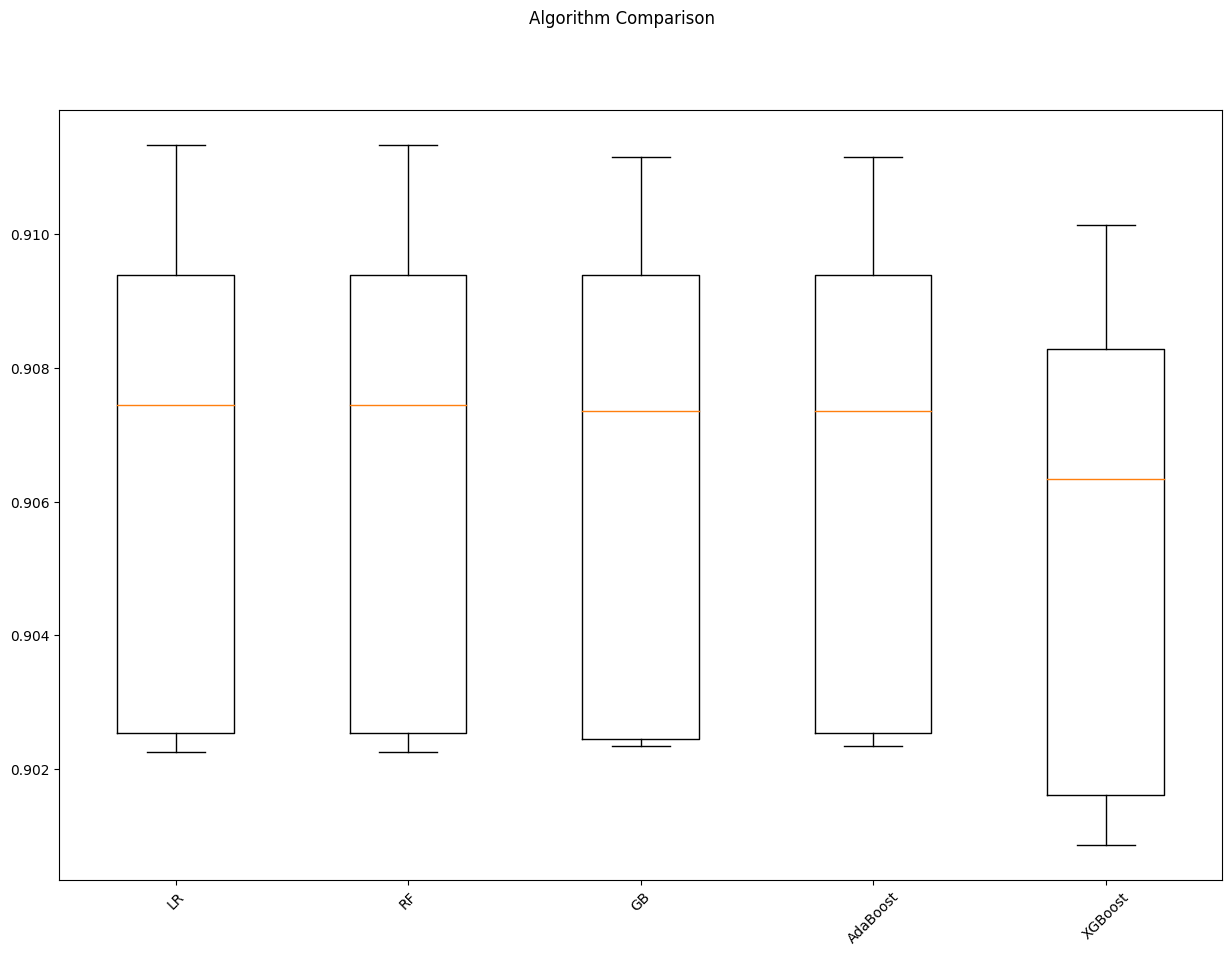

In [ ]:
# Algorithm Harness
# Scoring metrics:
# 'accuracy', 'balanced_accuracy', 'average_precision', 'neg_brier_score', 'f1', 'f1_micro', 'f1_macro', 'f1_weighted',
# 'neg_log_loss', 'precision', 'recall', 'jaccard', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted'
results = []
names = []

scoring = 'accuracy'
for name, model in models:
    start = time()
    kfold = KFold(n_splits=5, random_state=7, shuffle=True)
    model.fit(X_train, y_train)
    train_time = time() - start
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    predict_time = time() - start
    yhat = model.predict(X_test)
    yhat_train = model.predict(X_train)

      # evaluate predictions on training data
    accuracy_train = accuracy_score(y_train, yhat_train)
    roc_train=roc_auc_score(y_train, yhat_train)
    print("Accuracy for training data: %0.3fs", (accuracy_train*100))
    print("ROC for training data: %0.3fs", (roc_train))

   # evaluate predictions on Testing data
    accuracy_test = accuracy_score(y_test, yhat)
    roc_test=roc_auc_score(y_test, yhat)
    print("Accuracy for testing data:%0.3fs",  (accuracy_test*100))
    print("ROC for testing data: %0.3fs" ,(roc_test))

    #accuracy_test.append(accuracy_test)
    #roc_test.append(roc_test)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    print("Score for each of the 5 K-fold tests:",cv_results)
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print()

fig = pyplot.figure(figsize=(15, 10))  # Change the numbers as needed
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names, rotation = 45)  # Added rotation for better visibility
pyplot.show()

In [ ]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
#models.append(('Ridge', RidgeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')))
models.append(('GB', GradientBoostingClassifier()))
models.append(('AdaBoost', AdaBoostClassifier()))
#models.append(('KNN', KNeighborsClassifier()))


In [ ]:
# Algorithm Harness
# Scoring metrics:
# 'accuracy', 'balanced_accuracy', 'average_precision', 'neg_brier_score', 'f1', 'f1_micro', 'f1_macro', 'f1_weighted',
# 'neg_log_loss', 'precision', 'recall', 'jaccard', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted'
results = []
names = []
scoring = 'roc_auc'
for name, model in models:
    start = time()
    kfold = KFold(n_splits=5, random_state=7, shuffle=True)
    model.fit(X_train_so, y_train_so)
    train_time = time() - start
    cv_results = cross_val_score(model, X_train_so, y_train_so, cv=kfold, scoring=scoring)
    predict_time = time() - start
    yhat = model.predict(X_test)
    yhat_train = model.predict(X_train_so)

      # evaluate predictions on training data
    accuracy_train = accuracy_score(y_train_so, yhat_train)
    roc_train=roc_auc_score(y_train_so, yhat_train)
    print("Accuracy for training data: %0.3fs", (accuracy_train*100))
    print("ROC for training data: %0.3fs", (roc_train))

   # evaluate predictions on Testing data
    accuracy_test = accuracy_score(y_test, yhat)
    roc_test=roc_auc_score(y_test, yhat)
    print("Accuracy for testing data:%0.3fs",  (accuracy_test*100))
    print("ROC for testing data: %0.3fs" ,(roc_test))

    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    print("Score for each of the 5 K-fold tests: ",cv_results)
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print()

fig = pyplot.figure(figsize=(15, 10))  # Change the numbers as needed
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names, rotation = 45)  # Added rotation for better visibility
pyplot.show()

LogisticRegression(solver='liblinear')

Accuracy for training data: %0.3fs 53.55412945288071
ROC for training data: %0.3fs 0.535541294528807
Accuracy for testing data:%0.3fs 51.878751945453196
ROC for testing data: %0.3fs 0.5091827666151468
LR: 0.544370 (0.005352)
Score for each of the 5 K-fold tests:  [0.54811118 0.55298563 0.54180027 0.53997999 0.53897413]
LogisticRegression(solver='liblinear')
	Training time: 4.815s
	Prediction time: 25.457s



In [ ]:
print(roc_test)

[0.5102154053093471, 0.5, 0.5000764235765549, 0.5, 0.5]


## Final Model Selection and Variable Importance

In [ ]:

rf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
rf_model=rf.fit(X_train_so,y_train_so)
rf_model.feature_importances_

array([0.00121981, 0.00113345, 0.00126932, 0.04962318, 0.00125499,
       0.00128478, 0.00143252, 0.03163795, 0.00802545, 0.00170131,
       0.00832702, 0.00122909, 0.00134205, 0.00123749, 0.00240955,
       0.00136534, 0.0017553 , 0.00126405, 0.0013571 , 0.00119901,
       0.04199731, 0.0064675 , 0.02095824, 0.07958635, 0.06835735,
       0.02327511, 0.02937015, 0.0012297 , 0.00116231, 0.00500428,
       0.00493556, 0.00287874, 0.00927715, 0.00717277, 0.01560919,
       0.01155789, 0.01329725, 0.00737223, 0.02089049, 0.00484954,
       0.00467379, 0.01206315, 0.00500132, 0.00644035, 0.00384856,
       0.00339193, 0.00525333, 0.00430316, 0.00542989, 0.00525589,
       0.00219553, 0.00316077, 0.00126909, 0.00082656, 0.00152867,
       0.00141251, 0.00072487, 0.00039198, 0.00151595, 0.00139772,
       0.00112169, 0.00024137, 0.        , 0.03260771, 0.09053894,
       0.        , 0.00128125, 0.        , 0.000862  , 0.00049008,
       0.        , 0.        , 0.00147808, 0.        , 0.     

In [ ]:
x_name=df_mr.drop(columns=["loan_default_status"],axis=1)
importances=pd.DataFrame({'Features':x_name.columns,'Feature Importances':rf_model.feature_importances_})
importances

In [ ]:
imp = importances.sort_values(by='Feature Importances',ascending=False)
imp

<Axes: xlabel='Features', ylabel='Feature Importances'>

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146]),
 [Text(0, 0, 'loan_title_debt_consolidation'),
  Text(1, 0, 'loan_title_credit_card_refinancing'),
  Text(2, 0, 'home_ownership_rent'),
  Text(3, 0, 'grade_b'),
  Text

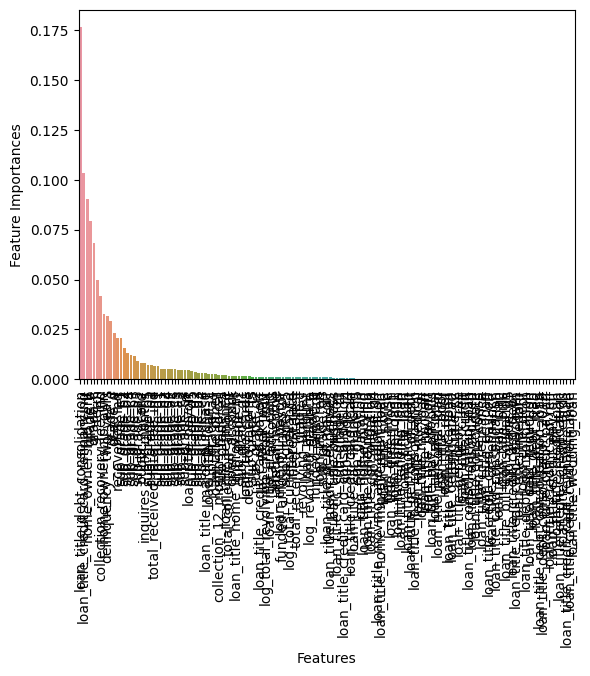

In [ ]:
sns.barplot(y='Feature Importances',x='Features',data=imp)
plt.xticks(rotation=90)
plt.show()

# Undersample

In [ ]:
#Undersample
trainData = pd.concat([X_train, y_train], axis=1)
trainData.head(1)

term  loan_default_status
3766  0.09649                    0

In [ ]:
# pull out all of the "1-Defaulters" or minority values
idx_defaulters = trainData[trainData.loan_default_status==1].index
print(len(idx_defaulters))

5006


In [ ]:
# Separate the minority class
defaulter_df = trainData.loc[idx_defaulters]
print(defaulter_df.shape)

(5006, 2)


In [ ]:
# now the majority
idx_nondefaulters = trainData[trainData.loan_default_status==0].index
print(len(idx_nondefaulters))

48964


In [ ]:
# Separate the majority class
nondefaulter_df = trainData.loc[idx_nondefaulters]
print(nondefaulter_df.shape)

(48964, 2)


In [ ]:
# Randomly pull out 5006 (idx_defaulters) from the Non Defaulters dataframe
defaulter_df_sample=nondefaulter_df.sample(n=len(idx_defaulters),random_state=123)
defaulter_df_sample.shape

(5006, 2)

In [ ]:
balanced_undersampled_df = pd.concat([defaulter_df, defaulter_df_sample], axis=0)
print(balanced_undersampled_df.loan_default_status.value_counts())
# Shuffling the data set
from sklearn.utils import shuffle
balanced_undersampled_df = shuffle(balanced_undersampled_df)
balanced_undersampled_df.head()

1    5006
0    5006
Name: loan_default_status, dtype: int64


term  loan_default_status
27757  0.097370                    1
27941  0.083114                    1
50075  0.082061                    0
3454   0.083338                    1
1392   0.097016                    0

In [ ]:
# Making the new X_train and y_train
X_trainNew = balanced_undersampled_df.iloc[:,0:len(balanced_undersampled_df.columns)-1]
y_trainNew = balanced_undersampled_df.loan_default_status
X_trainNew.head(3)

term
27757  0.097370
27941  0.083114
50075  0.082061

In [ ]:
#Recheck Accuracy Score
model_undersampled = LogisticRegression(solver='liblinear', random_state=12)
model_undersampled.fit(X_trainNew, y_trainNew)
# evaluate the model
yhat = model_undersampled.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

LogisticRegression(random_state=12, solver='liblinear')

Accuracy: 36.61


[[4055 8203]
 [ 350  885]]


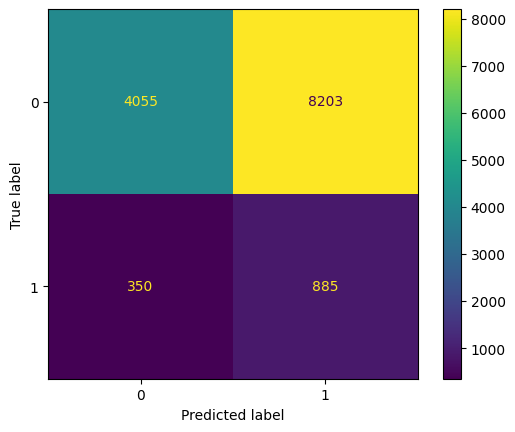

              precision    recall  f1-score   support

           0       0.92      0.33      0.49     12258
           1       0.10      0.72      0.17      1235

    accuracy                           0.37     13493
   macro avg       0.51      0.52      0.33     13493
weighted avg       0.85      0.37      0.46     13493



In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, yhat)
print(cm)
# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
print(classification_report(y_test, yhat))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, yhat)
print(fpr, tpr, thresholds)

[0.         0.66919563 1.        ] [0.         0.71659919 1.        ] [inf  1.  0.]


In [ ]:
roc_auc = auc(fpr, tpr)
roc_auc

0.5237017814689968

<Figure size 500x500 with 0 Axes>

(-0.02, 1.02)

(-0.02, 1.02)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC curve')

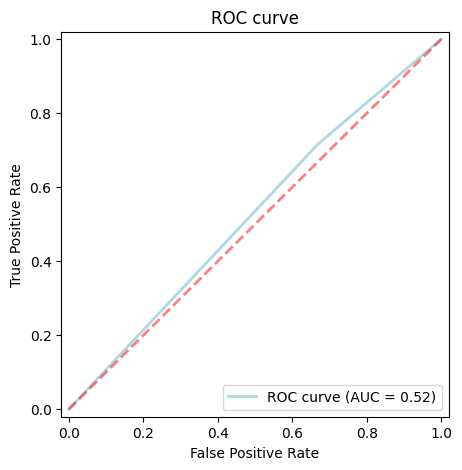

In [ ]:
#plot roc curve

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='lightblue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Oversample

In [ ]:
!pip install smote-variants

In [ ]:
# Shape before oversampling
print("Before OverSampling count of Defaulters: {}".format(sum(y_train==1)))
print("Before OverSampling count of Non-Defaulters: {} \n".format(sum(y_train==0)))

Before OverSampling count of Defaulters: 5006
Before OverSampling count of Non-Defaulters: 48964 



In [ ]:
import smote_variants as sv
# Instantiating the SMOTE class
oversampler= sv.SMOTE()
# Creating new training set
X_train_os, y_train_os = oversampler.sample(np.array(X_train), np.array(y_train))

2023-10-17 21:34:54,050:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'SMOTE'}")
INFO:smote_variants:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'SMOTE'}")
2023-10-17 21:34:54,056:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-10-17 21:34:54,072:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-10-17 21:34:54,103:INFO:SMOTE: simplex sampl

In [ ]:
# Shape after oversampling
print('After OverSampling, the shape of X_train: {}'.format(X_train_os.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_train_os.shape))
print("After OverSampling, counts of Defaulters: {}".format(sum(y_train_os==1)))
print("After OverSampling, counts of label Non-Defaulters: {}".format(sum(y_train_os==0)))

After OverSampling, the shape of X_train: (97928, 1)
After OverSampling, the shape of y_train: (97928,) 

After OverSampling, counts of Defaulters: 48964
After OverSampling, counts of label Non-Defaulters: 48964


In [ ]:
#Recheck Accuracy Score
model_oversampled = LogisticRegression(solver='liblinear', random_state=12)
model_oversampled.fit(X_train_os, y_train_os)
# evaluate the model
yhat = model_oversampled.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 36.61


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


[[4055 8203]
 [ 350  885]]


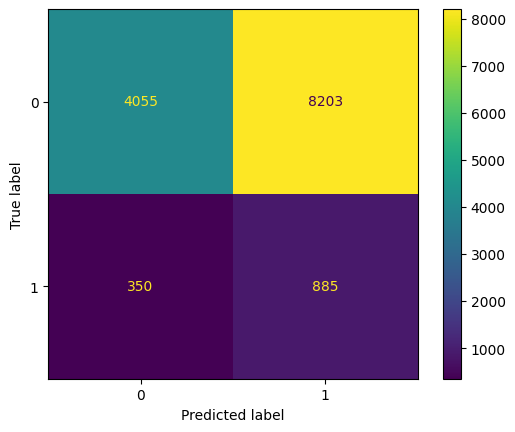

              precision    recall  f1-score   support

           0       0.92      0.33      0.49     12258
           1       0.10      0.72      0.17      1235

    accuracy                           0.37     13493
   macro avg       0.51      0.52      0.33     13493
weighted avg       0.85      0.37      0.46     13493



In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, yhat)
print(cm)
# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
print(classification_report(y_test, yhat))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, yhat)
print(fpr, tpr, thresholds)

[0.         0.66919563 1.        ] [0.         0.71659919 1.        ] [inf  1.  0.]


In [ ]:
roc_auc = auc(fpr, tpr)
roc_auc

0.5237017814689968

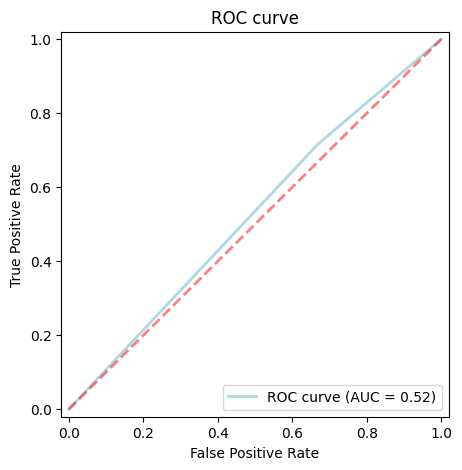

In [ ]:
#plot roc curve

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='lightblue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

2023-10-17 21:36:14,172:INFO:MSMOTE: Running sampling via ('MSMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'random_state': None, 'class_name': 'MSMOTE'}")
INFO:smote_variants:MSMOTE: Running sampling via ('MSMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'random_state': None, 'class_name': 'MSMOTE'}")
2023-10-17 21:36:14,185:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-10-17 21:36:14,224:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski


After OverSampling, the shape of X_train: (97928, 1)
After OverSampling, the shape of y_train: (97928,) 

After OverSampling, counts of Defaulters: 48964
After OverSampling, counts of label Non-Defaulters: 48964
Accuracy: 36.61
[[4055 8203]
 [ 350  885]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


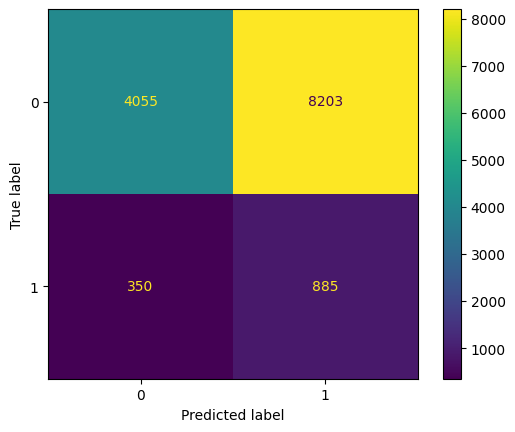

              precision    recall  f1-score   support

           0       0.92      0.33      0.49     12258
           1       0.10      0.72      0.17      1235

    accuracy                           0.37     13493
   macro avg       0.51      0.52      0.33     13493
weighted avg       0.85      0.37      0.46     13493



In [ ]:
# Instantiating the MSMOTE class
oversampler= sv.MSMOTE()

# Creating new training set
X_train_os, y_train_os = oversampler.sample(np.array(X_train), np.array(y_train))
# Shape after oversampling
print('After OverSampling, the shape of X_train: {}'.format(X_train_os.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_train_os.shape))
print("After OverSampling, counts of Defaulters: {}".format(sum(y_train_os==1)))
print("After OverSampling, counts of label Non-Defaulters: {}".format(sum(y_train_os==0)))

#Recheck Accuracy Score
model_oversampled = LogisticRegression(solver='liblinear', random_state=12)
model_oversampled.fit(X_train_os, y_train_os)
# evaluate the model
yhat = model_oversampled.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

# Compute confusion matrix
cm = confusion_matrix(y_test, yhat)
print(cm)
# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
print(classification_report(y_test, yhat))

In [ ]:
roc_auc = auc(fpr, tpr)
roc_auc

0.5237017814689968

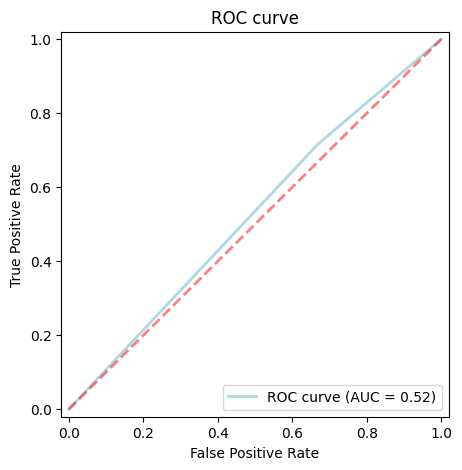

In [ ]:
#plot roc curve

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='lightblue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Test Logistic Regression using DictVectorizer Input

In [ ]:

# split into train and test sets
df_X_train_test = df.drop(columns='loan_default_status', axis=1).to_dict(orient='records')

#DictVectorizer can be used in Neural Networks
dv = DictVectorizer(sparse=False)
dv.fit(df_X_train_test)
X = dv.transform(df_X_train_test)

X_train_dv, X_test_dv, y_train_dv, y_test_dv = train_test_split(X, df.loan_default_status, test_size=0.20, random_state=10)
model = LogisticRegression(solver='liblinear', random_state=12)
model.fit(X_train_dv, y_train_dv)
# evaluate the model
y_pred = model.predict(X_test_dv)
# evaluate predictions
accuracy = accuracy_score(y_test_dv, y_pred)
print('Accuracy: %.2f' % (accuracy*100))


In [ ]:
#Test Input
customer={'loan_amount': 458929,
 'funded_amount': 89564,
 'funded_amount_investor': 250000,
 'term': 120,
 'batch_enrolled': 'bat2522922',
 'interest_rate': 8.75,
 'grade': 'Z',
 'sub_grade': 'Z4',
 'home_ownership': 'own',
 'annual_income': 190000,
 'loan_title': 'debt_consolidation',
 'debit_to_income': 12.84758,
 'delinquency_-_two_years': 10,
 'inquires_-_six_months': 10,
 'open_account': 3,
 'public_record': 0,
 'revolving_balance': 0,
 'revolving_utilities': 99.74,
 'total_accounts': 17,
 'total_received_interest': 1500,
 'total_received_late_fee': 5,
 'recoveries': 4,
 'collection_recovery_fee': 0,
 'collection_12_months_medical': 0,
 'last_week_pay': 24,
 'total_collection_amount': 0,
 'total_current_balance': -237847,
 'total_revolving_credit_limit': -3458.0}

X_test_inp = dv.transform([customer])
#model.predict_proba(X_test)[0,1]
# evaluate the model
ypred = model.predict(X_test_inp)
# evaluate predictions
accuracy = accuracy_score(y_test_dv, y_pred)
print('Accuracy: %.2f' % (accuracy*100))

# Neural Network Model

In [ ]:
#using Dict Vectorizer
# split into train and test sets
df_X_train_test = df.drop(columns='loan_default_status', axis=1).to_dict(orient='records')

#DictVectorizer can be used in Neural Networks
dv = DictVectorizer(sparse=False)
dv.fit(df_X_train_test)
dv.feature_names_
X = dv.transform(df_X_train_test)